In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import copy
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import imageio.v2 as imageio
from IPython.display import Markdown, display, Video, Javascript
from io import BytesIO

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from utils import computation_graph_linear, squared_loss_function

In [2]:
## generate polinomial features.
def generate_features(x, poly_degree, add_bias = True):
    feat = []
    
    for i in range(poly_degree+1):
        feat.append(x**i)
        
    # remove bias term (ones) if requested 
    if not add_bias:
        feat = feat[1:]
        
    return np.column_stack(tuple(feat))

## Generates sinusoidal data
def generate_sinusoidal_data(xmin, xmax, frequency, noise_var, N, seed = None):
    if seed is not None:
        np.random.seed(seed)
    x_train = (xmax - xmin) * np.random.random_sample((N,1)) + xmin
    t_train = np.sin(frequency*x_train) + 0.3 * x_train 
    t_train += np.random.normal(0, noise_var, size=x_train.shape)
    return x_train, t_train

## generates polinomial data
def generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N, w_true = None, seed = None):
    if seed is not None:
        np.random.seed(seed)
    if w_true is None:
        w_true = np.array([[2],[-1.5],[0.9]])
    x_train = (xmax - xmin) * np.random.random_sample((N,1)) + xmin
    X_feats = generate_features(x_train, poly_degree)
    t_train = computation_graph_linear(X_feats, w_true, b = 0) + np.random.normal(0, noise_var, size=x_train.shape[0])[:,np.newaxis]
    return x_train, t_train

##
def sinusoidal_fun(x_locs, frequency):
    return np.sin(frequency*x_locs) + 0.3 * x_locs

def fit_norm2_least_square(X,T, lam = 0):

    # Obtain optimum model
    XtX = np.transpose(X) @ X
    Xty = np.transpose(X) @ T

    XtX += lam * np.eye(XtX.shape[0])

    # withouth regularization
    w_opt = np.linalg.solve(XtX, Xty)
    
    return w_opt

def norm_data(X, mean = None, std = None ):
    if mean is None:
        mean = np.mean(X, axis = 0)
        std  = np.std(X, axis = 0)

    return  (X - mean) / std, mean, std

$$
\newcommand{\x}{\mathbf{x}}
\newcommand{\w}{\mathbf{w}}
\newcommand{\z}{\mathbf{z}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\t}{\mathbf{t}}
\newcommand{\Z}{\mathbf{Z}}
\newcommand{\Y}{\mathbf{Y}}
\newcommand{\X}{\mathbf{X}}
\newcommand{\W}{\mathbf{W}}
\newcommand{\T}{\mathbf{T}}
\newcommand{\I}{\mathbf{I}}
\newcommand{\J}{\mathbf{J}}
\newcommand{\dd}{\text{d}}
\newcommand{\vec}{\text{vec}}
$$

# Multivariate Regression, Overfitting, Regularization and Cross Validation

This document covers multivariate regression, overfitting, regularization and cross validation. To do so we will use polynomial regression model.

First, note that linear models can be written in matrix form in the following way, with independence of the task considered; because is the link function what takes this into account.

For any dataset $\x \in \mathbb{R^d}$ we can use a weight vector $\w \in \mathbb{R^{d+1}}$. By concatenating a $1$ to $\x$ we can express linear regression by the following dot product:

\begin{split}
\z &= \x^T\w = \sum^d_{i=1} x_i \cdot w_i + \cancelto{b}{1\cdot w_0}\\
\y &= \Phi(\z)
\end{split}

If we are given $N$ training instances, we know the loss is a sum over all predictions. For example for the squared loss we would have:

\begin{split}
L(\w,\x,\t) &= \sum^N_{n=1}(\t_n - \Phi\left(\x_n^T \cdot \w\right))^2\\
&= \sum^N_{n=1}(\t_n - \Phi\left(\sum^d_{i=1} x_{n,i} \cdot w_i + b\right))^2
\end{split}

This can be compactly represented using matrix multiplications as follows. Consider stacking all training instance in a matrix $\X$ such that each row represents a datapoint and each column a feature. This means that $\X \in \mathbb{R}^{N \times d}$. This is also known as the design matrix. On the other hand, we could express $\T$ as a matrix where each row represents the corresponding targets to each datapoint and each column all variables being regressed. This obviously generalizes the concept of regressing one single output variable to multiple output variables. In this case, instead of having a vector $\w$ we would have a matrix $\W\in\mathbb{R}^{d\times o}$, with $o$ being the number of outputs.

With this, predictions $\Y$ can be obtained through:

\begin{split}
\Z &= \X\W\\
\Y &= \Phi(\Z)
\end{split}

When the regressed variable is one dimensional, the square loss function can be written down  through the square of the $L_2$ norm between $\T$ and $\Y$, basically because the square loss is the element-wise square sum between all the elements in the vectors. For multioutput regression we use what is call the Frobenius norm. For both cases the notation is given by:

\begin{split}
L(\X,\T,\W) = ||\T - \X\W||^2_2
\end{split}

with the only difference of using $\w$ or $\W$. We will now workout the general case for multioutput regression since one single variable regression is a special case.

Obtaining the Jacobian or gradient from this expression can be done as follows. We will use the chain rule and some rules from differential calculus. First of all note that we can express this loss function through the following composition:


\begin{split}
\Y &= \X\W \\
\Z &= \T - \Y \\
L(\Z) &= ||\Z||^2_2
\end{split}

So we need to take derivative of each individual functions and then multiply. First, note that:

\begin{split}
||\Z||^2_2 = \text{Tr}[\Z^T\Z]
\end{split}

The Jacobian from these expressions can be obtained by obtaining the first order differential, expressing it in its canonical form, and then obtaining the Jacobian from it. The canonical form from the first order differential can be written in two forms. I will use the one that uses vectorized expressions (further information and references here https://arxiv.org/pdf/2506.23996). The first order differential of a scalar valued, matrix functions is given by:

\begin{split}
\dd y = [\text{vec} A]^T \dd\text{vec} \X
\end{split}

If we know work the differential on the trace expression till yield the canonical form we have (applying rules of differentials that can be found in the above reference and matrix tricks from the matrix cookbook):

\begin{split}
\dd \text{Tr}[\Z^T\Z] &=  \text{Tr}[\dd[\Z^T]\Z + \Z^T\dd\Z]\\
&=\text{Tr}[\Z^T\dd\Z + \Z^T\dd\Z] \\
&=2\text{Tr}[\Z^T\dd\Z] \\
&=2[\vec\Z]^T\dd\vec\Z
\end{split}

The Jacobian of the next expression is very simple to compute again using rules of differentials. In this case have a matrix valued matrix function, with canonical form given by:

\begin{split}
\dd \vec\Y = A \dd \vec \X
\end{split}

In our case we have:

\begin{split}
\dd\vec[\T - \Y] = -\dd\vec\Y
\end{split}

so here the Jacobian is given by $-\I$. Finally, we have a matrix valued matrix function. The canonical form is the same as before and so we have:

\begin{split}
\dd\vec\Y &= \dd\vec[\X\W] \\
&= \vec[\X\dd\W \I]\\
& =[\I \otimes \X] \dd\vec\W
\end{split}


from where the Jacobian is given by $[\I \otimes \X]$. Now multiplying all terms applying the chain rule we have:

\begin{split}
\J_\w L(\X,\W,\T) &= -2[\vec[\T - \Y]]^T\I[\I \otimes \X] \\
&= - 2[\vec[\T - \X\W]]^T[\I \otimes \X]
\end{split}

Now since we are interested in the gradient we need to transpose the whole Jacobian which implies:

\begin{split}
\nabla_\w L(\X,\W,\T) &= \left(- 2[\vec[\T - \X\W]]^T[\I \otimes \X]\right)^T\\
&= -2 [\I \otimes \X^T]\vec[\T - \X\W]
\end{split}

Now set derivative to $0$ and solve for $\W$ we have:

\begin{split}
-2 [\I \otimes \X^T]\vec[\T - \X\W] &= 0\\
[\I \otimes \X^T]\vec[\T] - [\I \otimes \X^T]\vec[\X\W\I] &= 0\\
[\I \otimes \X^T]\vec[\T] - [\I \otimes \X^T](\I\otimes\X)\vec[\W] &= 0\\
[\I \otimes \X^T]\vec[\T] - [\I \otimes \X^T\X]\vec[\W] &= 0\\
[\I \otimes \X^T]\vec[\T]  &= [\I \otimes \X^T\X]\vec[\W]\\
\left([\I \otimes \X^T\X]\right)^{-1}[\I \otimes \X^T]\vec[\T]  &= \vec[\W]\\
[\I \otimes (\X^T\X)^{-1}][\I \otimes \X^T]\vec[\T]  &= \vec[\W]\\
[\I \otimes (\X^T\X)^{-1}\X^T]\vec[\T]  &= \vec[\W]\\
\vec[(\X^T\X)^{-1}\X^T\T\I]  &= \vec[\W]\\
\vec[(\X^T\X)^{-1}\X^T\T]  &= \vec[\W]
\end{split}

Undoing the vec operator on both sides yield optimal regression matrix given by:

\begin{split}
\W^*=(\X^T\X)^{-1}\X^T\T
\end{split}

This general case can be easily extrapolated to simpler cases for example considering only one regressed variable. The derivative can be made easier in these cases (**Exercise**)

Computation of the inverse should be done by running linear solver systems using the Cholesky factorization, i.e never use functions that invert a matrix. 

Overall, this means that any model can be fitted using this equation which has a computational cost dominated by $\mathcal{O}((N\times d)^3)$ due to inverse computation. This include a couple of models that might be of interest, because it holds for any model which is linear in the parameters, i.e., where predictions can be implemented using a dot product.

This includes model's we have seen so far which include general functions $f: \mathbb{R}^d \to \mathbb{R}$ which operates on different variables, with the particular case of $f: \mathbb{R} \to \mathbb{R}$ with two parameters which are $w$ and $b$. However, it turns out that we can have functions $f: \mathbb{R} \to \mathbb{R}$ with more parameters. One of these examples is known as polynomial regresion.


\begin{split}
y = \sum_{p=1}^P w_p x^p
\end{split}

For example if we want to fit a polynomial of order two then:

\begin{split}
y = w_0 + w_1 x + w_2 x^2 
\end{split}


and since the argument of the function is $x$ then we have functions from the reals into the reals.


## The lack of knowledge: Aleatoric and Epistemic Uncertainties

Let's fit some different polynomial to some data. We will generate data that follows a polynomial, and data that follows whatever other function, in this case it will be a combination of a linear and periodic functions.

To generate data that follows a polynomial of whatever order we randomly select $x$ points from within a domain in $\mathbb{R}$, and then for each point generate:

\begin{split}
t = \sum_{p=1}^P w_p x^p  + \epsilon;\,\, \epsilon \sim \mathcal{N}(\epsilon \mid 0, \sigma_\epsilon^2 )
\end{split}

The other function we will use is sinusoid with some frequency combined with a linear function. In other words:

\begin{split}
t = 0.3\cdot x + \sin(fx) + \epsilon;\,\, \epsilon \sim \mathcal{N}(\epsilon \mid 0, \sigma_\epsilon^2 )
\end{split}

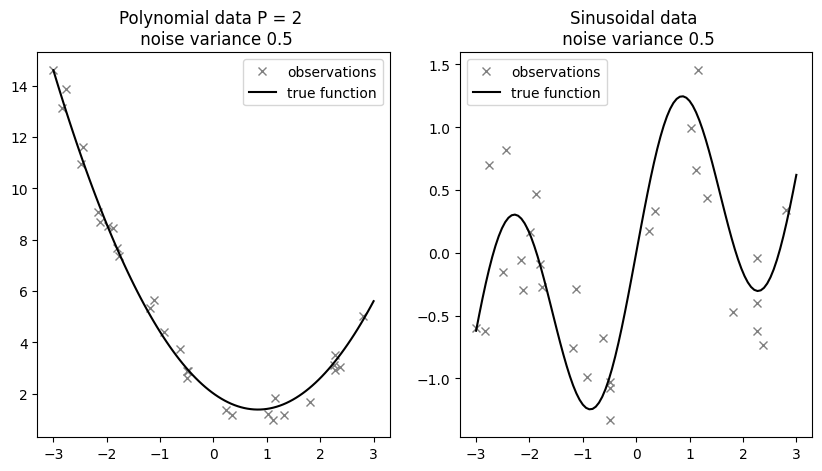

In [3]:
## data simulation generation
xmin = -3
xmax = 3
N_points = 30
noise_var = 0.5

# plot function
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# polinomial data
poly_degree = 2
X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)

# sinusoidal data
frequency = 2
X_train_sinu, t_train_sinu = generate_sinusoidal_data(xmin, xmax, frequency, noise_var, N_points, seed = 1)

# true functions
y_grid_poly = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )
y_grid_sinu = sinusoidal_fun(x_grid, frequency = frequency)

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))


ax1.plot(X_train_poly, t_train_poly , 'x', color = 'gray', label = 'observations')
ax1.plot(x_grid, y_grid_poly, color = 'k', label = 'true function')
ax1.set_title(f'Polynomial data P = {poly_degree} \n noise variance {noise_var}')
ax1.legend()


ax2.plot(X_train_sinu, t_train_sinu , 'x', color = 'gray', label = 'observations')
ax2.plot(x_grid, y_grid_sinu, color = 'k', label = 'true function')
ax2.set_title(f'Sinusoidal data \n noise variance {noise_var}')
ax2.legend()



Let's fit some polynomial models from different order, starting from order 1, which is a line.

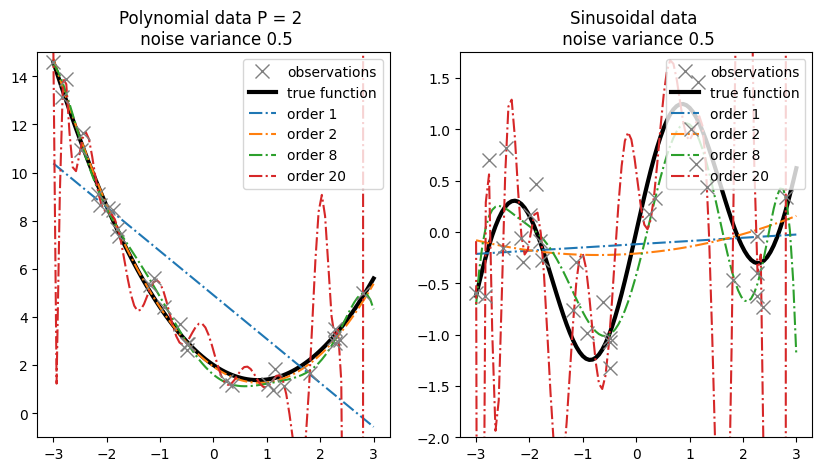

In [4]:
## Dataset specs generation
xmin = -3
xmax = 3
N_points = 30

# polinomial data
poly_degree = 2

# sinusoidal data
frequency = 2

# plot function
xmin = -3
xmax = 3
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# true functions
y_grid_poly_true = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )
y_grid_sinu_true = sinusoidal_fun(x_grid, frequency = frequency)

for noise_var in  [0.5]:

    # polinomial data
    X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)
    
    # sinusoidal data
    X_train_sinu, t_train_sinu = generate_sinusoidal_data(xmin, xmax, frequency, noise_var, N_points, seed = 1)
    
    ## plot data and true model
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
    
    ax1.plot(X_train_poly, t_train_poly , 'x', color = 'gray', label = 'observations', markersize = 10, zorder = 10)
    ax1.plot(x_grid, y_grid_poly_true, color = 'k', label = 'true function', linewidth = 3)
    ax1.set_title(f'Polynomial data P = {poly_degree} \n noise variance {noise_var}')
    ax1.legend()
    
    
    ax2.plot(X_train_sinu, t_train_sinu , 'x', color = 'gray', label = 'observations', markersize = 10, zorder = 10)
    ax2.plot(x_grid, y_grid_sinu_true, color = 'k', label = 'true function', linewidth = 3)
    ax2.set_title(f'Sinusoidal data \n noise variance {noise_var}')
    ax2.legend()
    
    for i,poly_order in enumerate([1,2,8,20]):
        
        ## generate polynomial features
        X_feat_poly = generate_features(X_train_poly, poly_order)
        X_feat_sinu = generate_features(X_train_sinu, poly_order)
        X_feat_grid = generate_features(x_grid, poly_order)
        
        # fit model to polynomial data
        w_opt_poly = fit_norm2_least_square( X_feat_poly , t_train_poly )
        
        # fit model to sinusoidal data
        w_opt_sinu = fit_norm2_least_square( X_feat_sinu, t_train_sinu )
        
        
        # draw function on fitted model
        y_grid_poly = computation_graph_linear(  
                                               X_feat_grid, 
                                               w_opt_poly ,
                                               b = 0 ,
                                            )
        
        y_grid_sinu = computation_graph_linear(  
                                           X_feat_grid, 
                                           w_opt_sinu ,
                                           b = 0 ,
                                        )
        
        ## plotting
        ax1.plot(x_grid, y_grid_poly , linestyle = '-.' ,color = f'C{i}', label = f'order {poly_order}')
        ax1.set_ylim([-1,15])
        ax1.legend(loc = 'upper right')
    
    
        ax2.plot(x_grid, y_grid_sinu, linestyle = '-.' , color = f'C{i}', label = f'order {poly_order}')
        ax2.set_ylim([-2,1.75])
        ax2.legend(loc = 'upper right')

We observe how more expressive models fit the data better, in other words, they are able to go through each data point exactly. The question now is, what model shall we prefer to choose? In machine learning, the optimal thing we can do is to choose a model which belongs to the family of models that has generate the data. This is what Bayes decision theory tell us (whilst there are disagreements out there when talking about data generating mechanism). When this does not happens, then we say the model is misspecified. This means that if our data is drawn from a polynomial function of order $2$ is preferable to fit this model and model the noise as such, than to fit a more expressive model that fits the data perfectly, because in this case the model will be also fitting noise which does belong to another part of the modelling process. We will now illustrate this concept more deepthly and provide easy paths to understand it.

Machine learning is, in essence, about modelling data through modelling uncertainty or lack of knowledge about how this data was generated. There are two sources of uncertainty: aleatoric uncertainty and epistemic uncertainty.

#### Aleatoric uncertainty

Aleatoric uncertainty is refered to the uncertainty (noise) present in the data, which in this case is modelled through the noise distribution $\mathcal{N}(\epsilon \mid 0, \sigma_\epsilon^2 )$. Let's see what happens when we increase the noise in the data, using way lot of data, i.e when the number of training points is high.

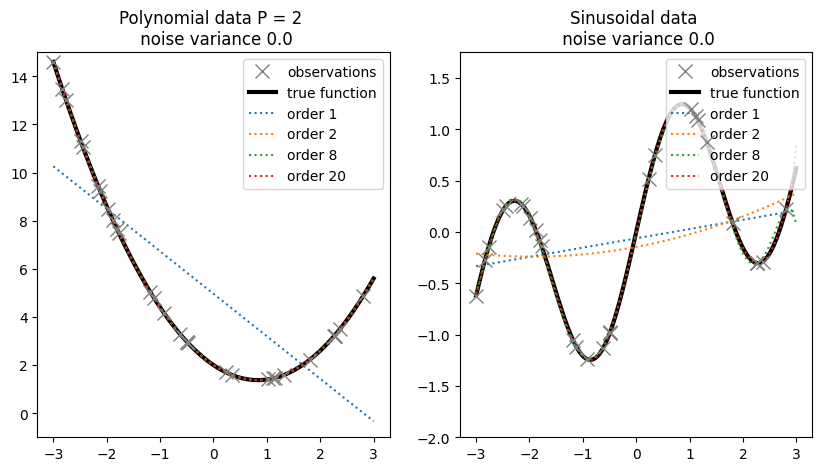

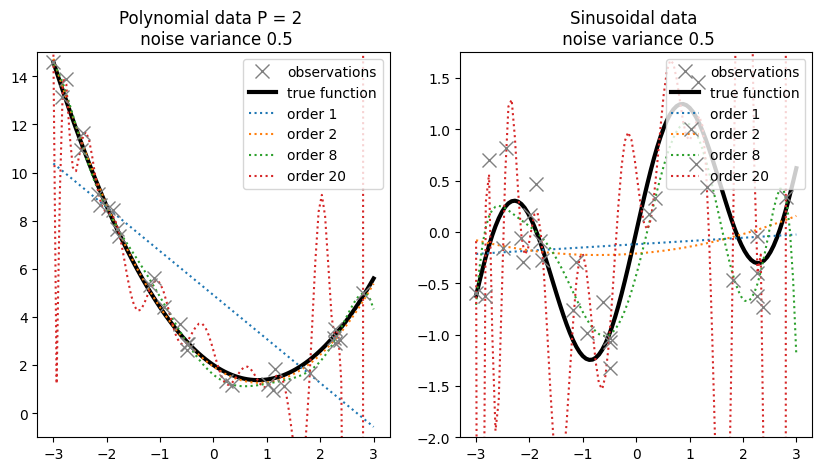

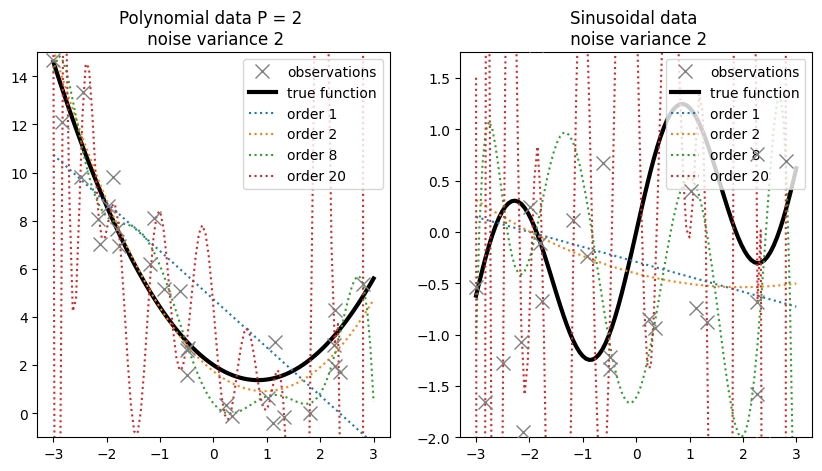

In [5]:
## Dataset specs generation
xmin = -3
xmax = 3
N_points = 30

# polinomial data
poly_degree = 2

# sinusoidal data
frequency = 2

# plot function
xmin = -3
xmax = 3
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# true functions
y_grid_poly_true = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )
y_grid_sinu_true = sinusoidal_fun(x_grid, frequency = frequency)

for noise_var in  [0.0, 0.5, 2]:

    # polinomial data
    X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)
    
    # sinusoidal data
    X_train_sinu, t_train_sinu = generate_sinusoidal_data(xmin, xmax, frequency, noise_var, N_points, seed = 1)
    
    ## plot data and true model
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
    
    ax1.plot(X_train_poly, t_train_poly , 'x', color = 'gray', label = 'observations', markersize = 10, zorder = 10)
    ax1.plot(x_grid, y_grid_poly_true, color = 'k', label = 'true function', linewidth = 3)
    ax1.set_title(f'Polynomial data P = {poly_degree} \n noise variance {noise_var}')
    ax1.legend()
    
    
    ax2.plot(X_train_sinu, t_train_sinu , 'x', color = 'gray', label = 'observations', markersize = 10, zorder = 10)
    ax2.plot(x_grid, y_grid_sinu_true, color = 'k', label = 'true function', linewidth = 3)
    ax2.set_title(f'Sinusoidal data \n noise variance {noise_var}')
    ax2.legend()
    
    for i,poly_order in enumerate([1,2,8,20]):
        
        ## generate polynomial features
        X_feat_poly = generate_features(X_train_poly, poly_order)
        X_feat_sinu = generate_features(X_train_sinu, poly_order)
        X_feat_grid = generate_features(x_grid, poly_order)
        
        # fit model to polynomial data
        w_opt_poly = fit_norm2_least_square( X_feat_poly , t_train_poly )
        
        # fit model to sinusoidal data
        w_opt_sinu = fit_norm2_least_square( X_feat_sinu, t_train_sinu )
        
        
        # draw function on fitted model
        y_grid_poly = computation_graph_linear(  
                                               X_feat_grid, 
                                               w_opt_poly ,
                                               b = 0 ,
                                            )
        
        y_grid_sinu = computation_graph_linear(  
                                           X_feat_grid, 
                                           w_opt_sinu ,
                                           b = 0 ,
                                        )
        
        ## plotting
        ax1.plot(x_grid, y_grid_poly , linestyle = ':' ,color = f'C{i}', label = f'order {poly_order}')
        ax1.set_ylim([-1,15])
        ax1.legend(loc = 'upper right')
    
    
        ax2.plot(x_grid, y_grid_sinu, linestyle = ':' , color = f'C{i}', label = f'order {poly_order}')
        ax2.set_ylim([-2,1.75])
        ax2.legend(loc = 'upper right')

We clearly observe how a more expressive model starts fitting the data better. Even though the data comes from a much simpler mechanims a more expressive model starts modelling noise as part of the functional modelling proceedure. This is something not desirable and we will see shortly how this can be measured. 

See how in the absence of noise this effect is not present, and the model fits the data as it should. Remember in this cases the solution is unique and is always computed using:

\begin{split}
\W^*=(\X^T\X)^{-1}\X^T\T
\end{split}

Just ask yourself, would you choose the red models to explain the data? Do you think this red models capture the underlying generative proceedure that generates our data?. Note that the number of training points was big enough to correctly retrieve the underlying functions, this is observed for the examples with less noise.

#### Epistemic uncertainty and model misspecification

The final observation is what happens when we have less data? Well, this is known as model uncertainty or espistemic uncertainty, which is the lack of knowledge due to data scarcity. 

To model this phenomena we need to generate less data. Even in the case we do not have aleatoric uncertainty we will observe this phenomena.

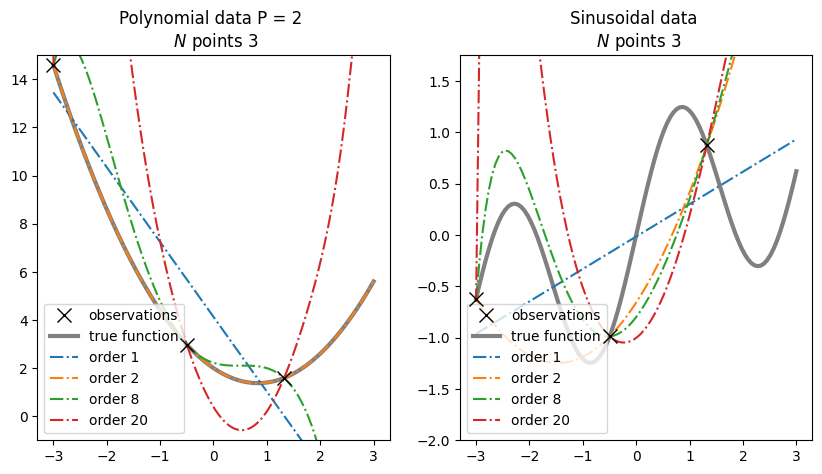

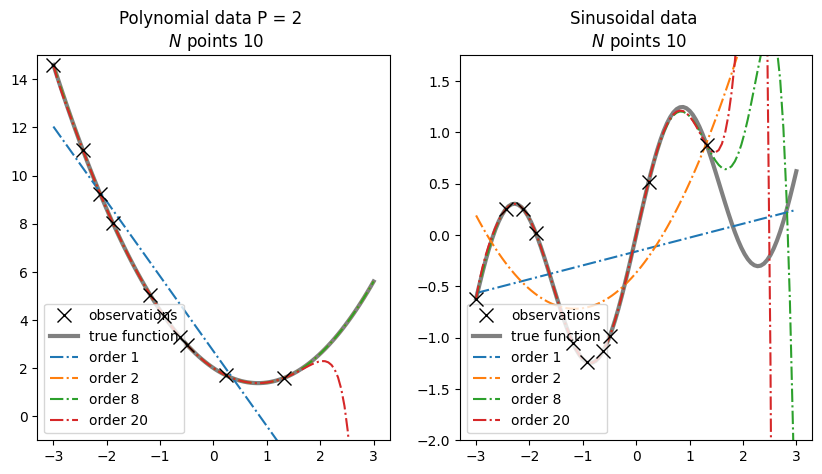

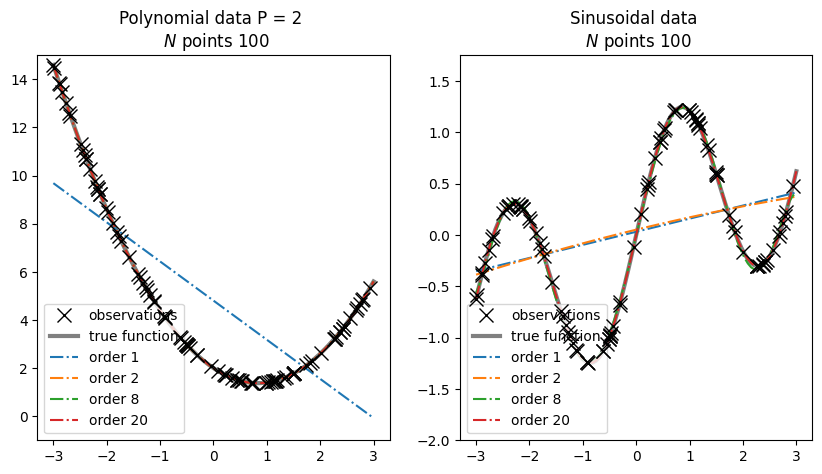

In [6]:
## Dataset specs generation
xmin = -3
xmax = 3

# polinomial data
poly_degree = 2

# sinusoidal data
frequency = 2

# plot function
xmin = -3
xmax = 3
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# true functions
y_grid_poly_true = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )
y_grid_sinu_true = sinusoidal_fun(x_grid, frequency = frequency)

for N_points in  [3, 10, 100]:

    noise_var = 0.0
    
    # polinomial data
    X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)
    
    # sinusoidal data
    X_train_sinu, t_train_sinu = generate_sinusoidal_data(xmin, xmax, frequency, noise_var, N_points, seed = 1)
    
    ## plot data and true model
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
    
    ax1.plot(X_train_poly, t_train_poly , 'x', color = 'k', label = 'observations', markersize = 10, zorder = 10)
    ax1.plot(x_grid, y_grid_poly_true, color = 'gray', label = 'true function', linewidth = 3)
    ax1.set_title(f'Polynomial data P = {poly_degree} \n $N$ points {N_points}')
    ax1.legend()
    
    
    ax2.plot(X_train_sinu, t_train_sinu , 'x', color = 'k', label = 'observations', markersize = 10, zorder = 10)
    ax2.plot(x_grid, y_grid_sinu_true, color = 'gray', label = 'true function', linewidth = 3)
    ax2.set_title(f'Sinusoidal data \n $N$ points {N_points}')
    ax2.legend()
    
    for i,poly_order in enumerate([1,2,8,20]):
        
        ## generate polynomial features
        X_feat_poly = generate_features(X_train_poly, poly_order)
        X_feat_sinu = generate_features(X_train_sinu, poly_order)
        X_feat_grid = generate_features(x_grid, poly_order)
        
        # fit model to polynomial data
        w_opt_poly = fit_norm2_least_square( X_feat_poly , t_train_poly )
        
        # fit model to sinusoidal data
        w_opt_sinu = fit_norm2_least_square( X_feat_sinu, t_train_sinu )
        
        
        # draw function on fitted model
        y_grid_poly = computation_graph_linear(  
                                               X_feat_grid, 
                                               w_opt_poly ,
                                               b = 0 ,
                                            )
        
        y_grid_sinu = computation_graph_linear(  
                                           X_feat_grid, 
                                           w_opt_sinu ,
                                           b = 0 ,
                                        )
        
        ## plotting
        ax1.plot(x_grid, y_grid_poly , linestyle = '-.' ,color = f'C{i}', label = f'order {poly_order}')
        ax1.set_ylim([-1,15])
        ax1.legend(loc = 'lower left')
    
    
        ax2.plot(x_grid, y_grid_sinu, linestyle = '-.' , color = f'C{i}', label = f'order {poly_order}')
        ax2.set_ylim([-2,1.75])
        ax2.legend(loc = 'lower left')

We observe a couple of interesting things. First note there is no noise in the data, so any lack of knowledge about how the data was generated comes from now being able to retrieve the underlying function. This can be clearly seen because when more data is retrieved, all models explain the underlying data mechanism, the second order polynomial, except the polynomial of order 1. In case of the sinusoidal data we need more expressive models and so polynomials of order 1 and 2 do not fit the data. All the uncertainty that comes from lack of knowledge is reduced when more knowledge is received. Thus, epistemic uncertainty is reducibled.

Second, we see that in the scenario of less data, polynomials due weird things, retrieving functions that do not have to do with the data generating process. This does not happens because the model is explaining noise, as before, because there is no noise in the data. This happens because there is now enought knowledge and a model with more parameters needs small tunning on its parameters to fit the data, which means that on unobserved regions the behaviour is unspecified. We will later talk about Occams Razzor to complete this claim.

Third, we see that the sinusoidal data is harder to explain by a polynomial. First of all note that polynomial functions (although being from a high order) encode the polynomial of order two within the family of plausible functions, so the model is well specified. For the sinusoidal data is not true and this misspecification is observed by a lack of fitting (see figure with  10 training points), needing more points to correctly retrieve the underlying function.


We can observe this is true for polynomial data generated from high order polynomial's, like $4$ or $8$.

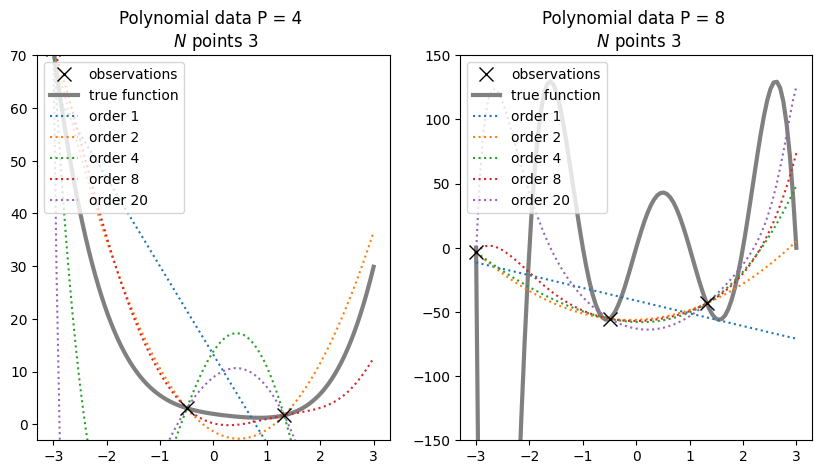

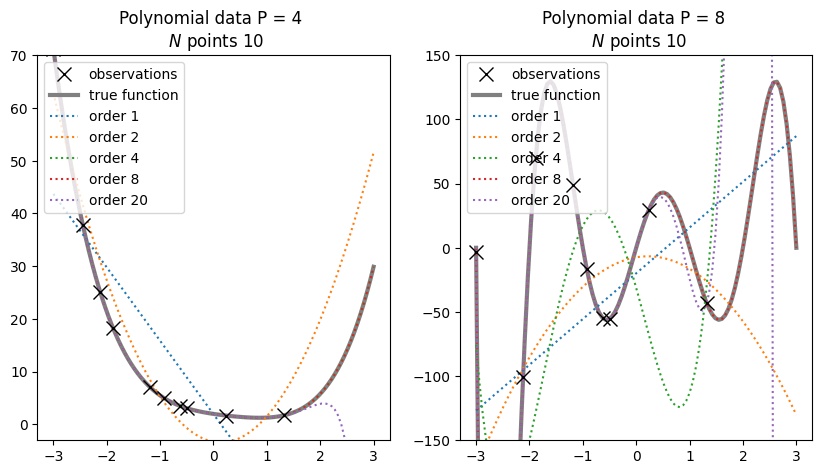

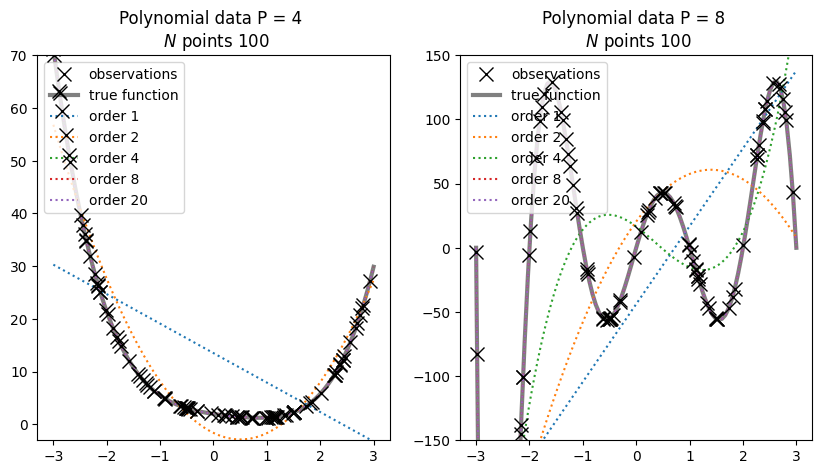

In [7]:
## Dataset specs generation
xmin = -3
xmax = 3

# polinomial data
poly_degree_1 = 4
poly_degree_2 = 8
w_true_1 = np.array([[2],[-1.5],[0.9],[-0.6],[0.5]])
w_true_2 = np.reshape(np.poly([-3, -2, -1, 0, 1, 2, 3, 4])[::-1],(poly_degree_2+1,1))

# plot function
xmin = -3
xmax = 3
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# true functions
y_grid_poly_true_1 = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree_1) , 
                                           w = w_true_1 ,
                                           b = 0 ,
                                        )

y_grid_poly_true_2 = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree_2) , 
                                           w = w_true_2 ,
                                           b = 0 ,
                                        )

for N_points in  [3, 10, 100]:

    noise_var = 0.0
    
    # polinomial data
    X_train_poly_1, t_train_poly_1 = generate_polinomial_data(
        xmin, 
        xmax, 
        poly_degree_1, 
        noise_var,
        N_points, 
        w_true = w_true_1, 
        seed = 1
    )
    
    # other polynomial
    X_train_poly_2, t_train_poly_2 = generate_polinomial_data(
        xmin, 
        xmax, 
        poly_degree_2, 
        noise_var,
        N_points, 
        w_true = w_true_2, 
        seed = 1
    )
     
    ## plot data and true model
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
    
    ax1.plot(X_train_poly_1, t_train_poly_1 , 'x', color = 'k', label = 'observations', markersize = 10, zorder = 10)
    ax1.plot(x_grid, y_grid_poly_true_1, color = 'gray', label = 'true function', linewidth = 3)
    ax1.set_title(f'Polynomial data P = {poly_degree_1} \n $N$ points {N_points}')
    ax1.legend()
    
    
    ax2.plot(X_train_poly_2, t_train_poly_2 , 'x', color = 'k', label = 'observations', markersize = 10, zorder = 10)
    ax2.plot(x_grid, y_grid_poly_true_2, color = 'gray', label = 'true function', linewidth = 3)
    ax2.set_title(f'Polynomial data P = {poly_degree_2} \n $N$ points {N_points}')
    ax2.legend()
    
    for i,poly_order in enumerate([1,2,4,8,20]):
        
        ## generate polynomial features
        X_feat_poly_1 = generate_features(X_train_poly_1, poly_order)
        X_feat_poly_2 = generate_features(X_train_poly_2, poly_order)
        X_feat_grid = generate_features(x_grid, poly_order)
        
        # fit model to polynomial data
        w_opt_poly_1 = fit_norm2_least_square( X_feat_poly_1 , t_train_poly_1 )
        
        # fit model to other polynomial data
        w_opt_poly_2 = fit_norm2_least_square( X_feat_poly_2 , t_train_poly_2 )
        
        
        # draw function on fitted model
        y_grid_poly_1 = computation_graph_linear(  
                                               X_feat_grid, 
                                               w_opt_poly_1 ,
                                               b = 0 ,
                                            )
        
        y_grid_poly_2 = computation_graph_linear(  
                                               X_feat_grid, 
                                               w_opt_poly_2 ,
                                               b = 0 ,
                                            )
        
        ## plotting
        ax1.plot(x_grid, y_grid_poly_1 , linestyle = ':' ,color = f'C{i}', label = f'order {poly_order}')
        ax1.set_ylim([-3,70])
        ax1.legend(loc = 'upper left')
    
    
        ## plotting
        ax2.plot(x_grid, y_grid_poly_2 , linestyle = ':' ,color = f'C{i}', label = f'order {poly_order}')
        ax2.set_ylim([-150,150])
        ax2.legend(loc = 'upper left')

In general we observe that, then the order of the polynomial is smaller than the one that the data has, then the curve tends to under fit the data, i.e. it does not correctly retrieve the underlying function due to lack of expresivness, and tends to somehow explan data on average. When the model is more expressive, the model overfits the data, i.e, it fits more than necessary to retrieve the underlying data generative process. More data solves this problem.

This is a well known problem from machine learning known as overfitting and underfitting. This effect is hard to diagnose from a visual point of view because data is usually high dimensional and visualization is not possible. However, there are many things we can do to observe this effect or to select models that have the perfect tradeoff between data fitting and model complexity.

In other words, we see that some models perfectly fits the data, which obviously gives a 0 error on the training set. The question now is, do we really want this behavior?. It turns out that our target in machine learning is to capture the underlying distribution in the data as to make predictions on unseen data. Let's mimic this behaviour and see how the function behaves on regions from the domain where is plausible to observe new data. To do this, we just generate more data according to the same generative proceedure we have used for the training data, and see which curves better explain this data.

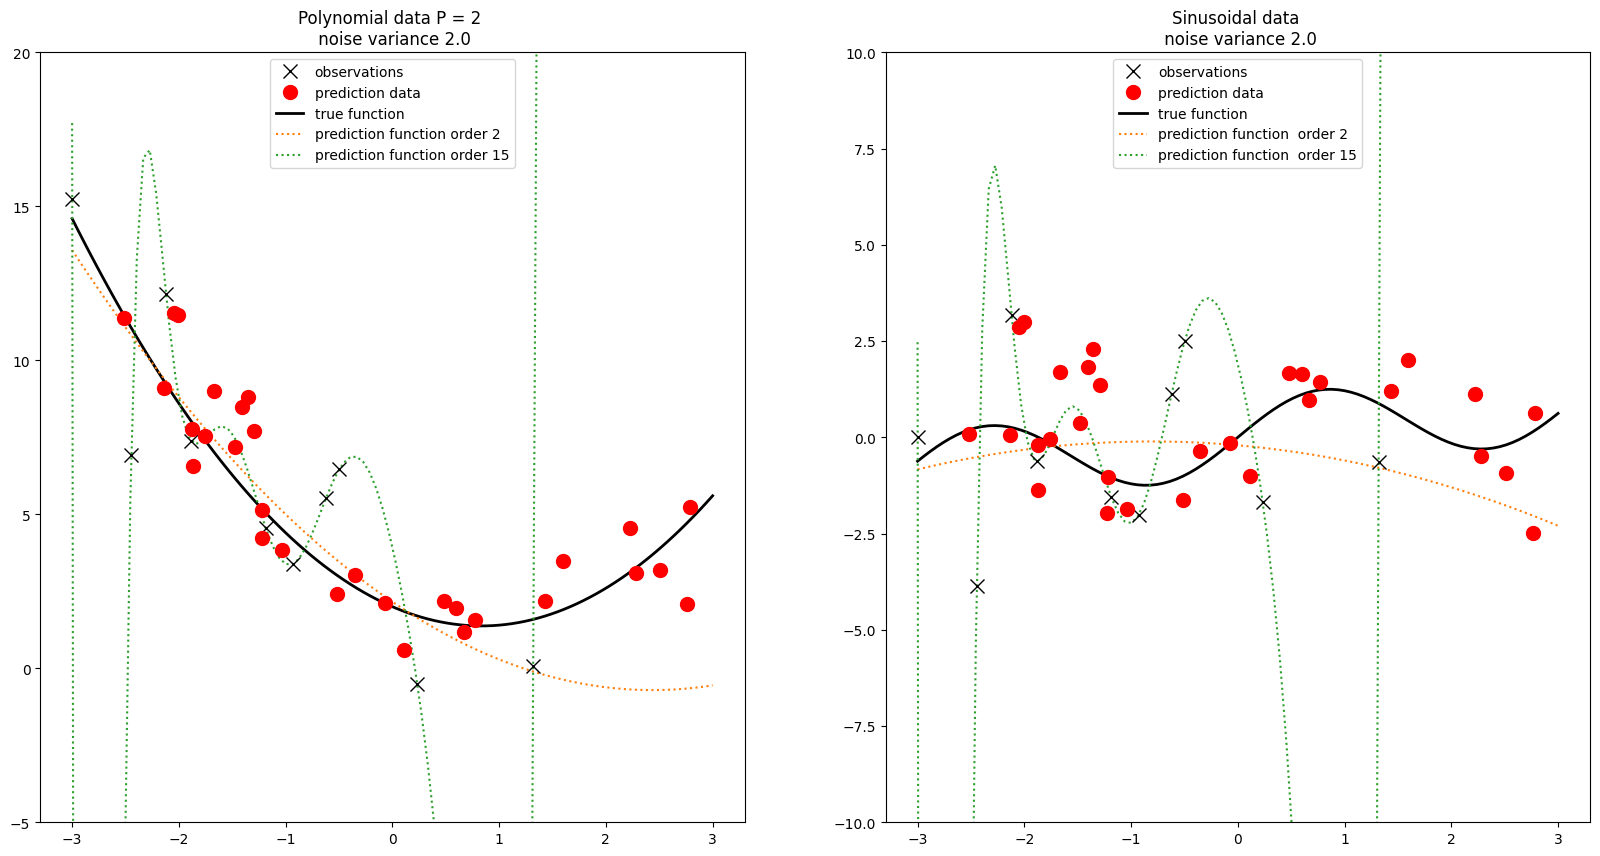

In [8]:
## Dataset generation
xmin = -3
xmax = 3
noise_var = 2.0
N_points = 10
N_test = 30

# polinomial data
poly_degree = 2
X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)
X_test_poly, t_test_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_test, seed = 5)

# sinusoidal data
frequency = 2
X_train_sinu, t_train_sinu = generate_sinusoidal_data(xmin, xmax, frequency, noise_var, N_points, seed = 1)
X_test_sinu, t_test_sinu = generate_sinusoidal_data(xmin, xmax, frequency, noise_var, N_test, seed = 5)

# plot function
xmin = -3
xmax = 3
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# true functions
y_grid_poly = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )
y_grid_sinu = sinusoidal_fun(x_grid, frequency = frequency)

## plot data and true model
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (20,10))

ax1.plot(X_train_poly, t_train_poly , 'x', color = 'k', label = 'observations', markersize = 10, zorder = 200)
ax1.plot(X_test_poly, t_test_poly , 'o', color = 'red', label = 'prediction data', markersize = 10, zorder = 200)
ax1.plot(x_grid, y_grid_poly, color = 'k', label = 'true function', linewidth = 2)
ax1.set_title(f'Polynomial data P = {poly_degree} \n noise variance {noise_var}')
ax1.legend()


ax2.plot(X_train_sinu, t_train_sinu , 'x', color = 'k', label = 'observations', markersize = 10, zorder = 200)
ax2.plot(X_test_sinu, t_test_sinu , 'o', color = 'red', label = 'prediction data', markersize = 10, zorder = 200)
ax2.plot(x_grid, y_grid_sinu, color = 'k', label = 'true function', linewidth = 2)
ax2.set_title(f'Sinusoidal data \n noise variance {noise_var}')
ax2.legend()

for i,poly_order in enumerate([2,15]):

    ## generate polynomial features
    X_feat_poly = generate_features(X_train_poly, poly_order)
    X_feat_sinu = generate_features(X_train_sinu, poly_order)
    X_feat_grid = generate_features(x_grid, poly_order)

    # fit model to polynomial data
    w_opt_poly = fit_norm2_least_square( X_feat_poly , t_train_poly )

    # fit model to sinusoidal data
    w_opt_sinu = fit_norm2_least_square( X_feat_sinu, t_train_sinu )


    # draw function on fitted model
    y_grid_poly = computation_graph_linear(  
                                           X_feat_grid, 
                                           w_opt_poly ,
                                           b = 0 ,
                                        )

    y_grid_sinu = computation_graph_linear(  
                                       X_feat_grid, 
                                       w_opt_sinu ,
                                       b = 0 ,
                                    )

    ## plotting
    ax1.plot(x_grid, y_grid_poly ,':', color = f'C{i+1}', label = f'prediction function order {poly_order}')
    ax1.set_ylim([-5,20])
    ax1.legend()


    ax2.plot(x_grid, y_grid_sinu ,':', color = f'C{i+1}', label = f'prediction function  order {poly_order}')
    ax2.set_ylim([-10,10])
    ax2.legend()

#### Overfitting

It turns out that the more expressive model does not make good predictions on new data, yet perfectly fitting the training set, as we observe in this figure. How can we measure this mathematically?. Well, we can use a performance metric. In this case the performance metric to use is exactly the expected distance between the function and each point. In other words, the same function is used for training, is used to measure performance. However, we could use other functions such as the absolute distance, the mape or many more. Performance metrics are associated to Bayes decision theory and, at least by the time of writting this, will be out of the scope of this subject.

So we will quantify how well the model behaves by measuring, over both the training and test sets the sum of squared errors. Let's plot it alongised the pictures.

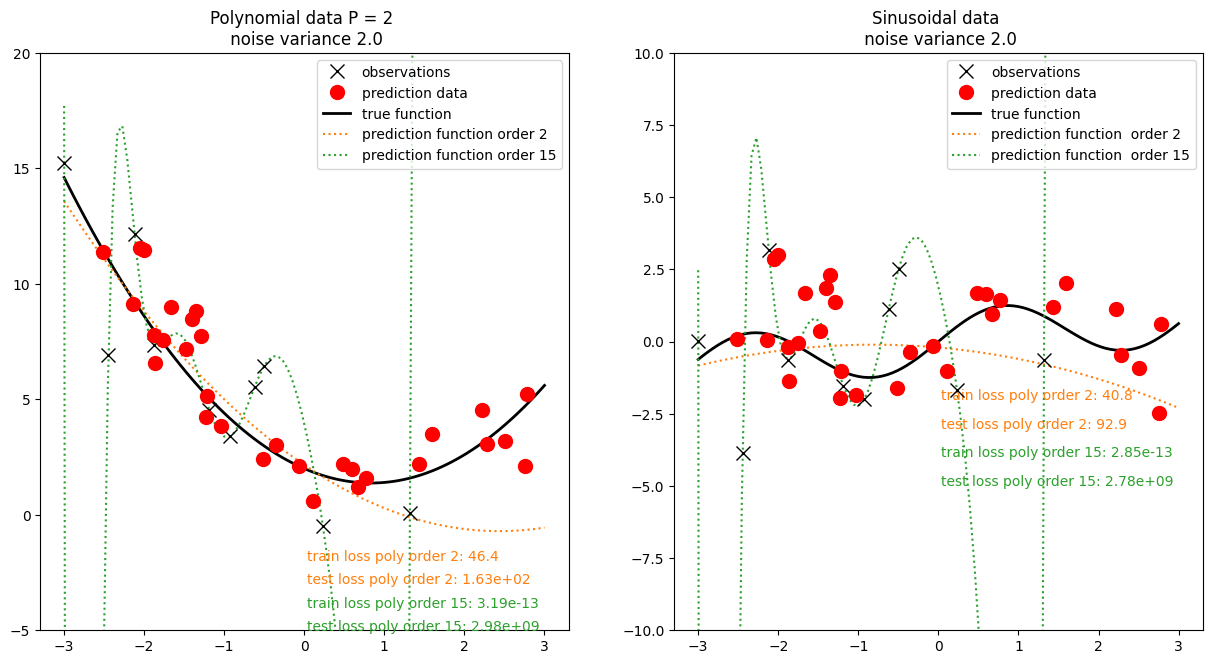

In [9]:
## Dataset generation
xmin = -3
xmax = 3
noise_var = 2.0
N_points = 10
N_test = 30

# polinomial data
poly_degree = 2
X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)
X_test_poly, t_test_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_test, seed = 5)

# sinusoidal data
frequency = 2
X_train_sinu, t_train_sinu = generate_sinusoidal_data(xmin, xmax, frequency, noise_var, N_points, seed = 1)
X_test_sinu, t_test_sinu = generate_sinusoidal_data(xmin, xmax, frequency, noise_var, N_test, seed = 5)

# plot function
xmin = -3
xmax = 3
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# true functions
y_grid_poly = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )
y_grid_sinu = sinusoidal_fun(x_grid, frequency = frequency)

## plot data and true model
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,7.5))

ax1.plot(X_train_poly, t_train_poly , 'x', color = 'k', label = 'observations', markersize = 10, zorder = 200)
ax1.plot(X_test_poly, t_test_poly , 'o', color = 'red', label = 'prediction data', markersize = 10, zorder = 200)
ax1.plot(x_grid, y_grid_poly, color = 'k', label = 'true function', linewidth = 2)
ax1.set_title(f'Polynomial data P = {poly_degree} \n noise variance {noise_var}')
ax1.legend()


ax2.plot(X_train_sinu, t_train_sinu , 'x', color = 'k', label = 'observations', markersize = 10, zorder = 200)
ax2.plot(X_test_sinu, t_test_sinu , 'o', color = 'red', label = 'prediction data', markersize = 10, zorder = 200)
ax2.plot(x_grid, y_grid_sinu, color = 'k', label = 'true function', linewidth = 2)
ax2.set_title(f'Sinusoidal data \n noise variance {noise_var}')
ax2.legend()

for i,poly_order in enumerate([2,15]):

    ## generate polynomial features
    X_feat_train_poly = generate_features(X_train_poly, poly_order)
    X_feat_train_sinu = generate_features(X_train_sinu, poly_order)
    X_feat_test_poly = generate_features(X_test_poly, poly_order)
    X_feat_test_sinu = generate_features(X_test_sinu, poly_order)
    X_feat_grid = generate_features(x_grid, poly_order)

    # fit model to polynomial data
    w_opt_poly = fit_norm2_least_square( X_feat_train_poly , t_train_poly )

    # fit model to sinusoidal data
    w_opt_sinu = fit_norm2_least_square( X_feat_train_sinu, t_train_sinu )


    # draw function on fitted model
    y_grid_poly = computation_graph_linear(  
                                           X_feat_grid, 
                                           w_opt_poly ,
                                           b = 0 ,
                                        )

    y_grid_sinu = computation_graph_linear(  
                                       X_feat_grid, 
                                       w_opt_sinu ,
                                       b = 0 ,
                                    )
    
    ## predictions on train and test set
    y_pred_train_poly = computation_graph_linear(  
                                                   X_feat_train_poly, 
                                                   w_opt_poly ,
                                                   b = 0 ,
                                                )
    
    y_pred_train_sinu = computation_graph_linear(  
                                                   X_feat_train_sinu, 
                                                   w_opt_sinu ,
                                                   b = 0 ,
                                                )

    y_pred_test_poly = computation_graph_linear(  
                                                   X_feat_test_poly, 
                                                   w_opt_poly ,
                                                   b = 0 ,
                                                )
    
    y_pred_test_sinu = computation_graph_linear(  
                                                   X_feat_test_sinu, 
                                                   w_opt_sinu ,
                                                   b = 0 ,
                                                )
    

    ## compute loss on the train and test sets
    loss_train_poly = np.sum(squared_loss_function( y_pred_train_poly, t_train_poly ))
    loss_train_sinu = np.sum(squared_loss_function( y_pred_train_sinu, t_train_sinu ))
    
    loss_test_poly = np.sum(squared_loss_function( y_pred_test_poly, t_test_poly ))
    loss_test_sinu = np.sum(squared_loss_function( y_pred_test_sinu, t_test_sinu ))
    
    ## plotting
    ax1.plot(x_grid, y_grid_poly, ':' , color = f'C{i+1}', label = f'prediction function order {poly_order}')
    ax1.text(x_grid[-50],-2 -2*i, f'train loss poly order {poly_order}: {loss_train_poly:.3}', color = f'C{i+1}')
    ax1.text(x_grid[-50],-2 -2*(i+1)+1, f'test loss poly order {poly_order}: {loss_test_poly:.3}', color = f'C{i+1}')
    ax1.set_ylim([-5,20])
    ax1.legend()

    ax2.plot(x_grid, y_grid_sinu, ':' , color = f'C{i+1}', label = f'prediction function  order {poly_order}')
    ax2.text(x_grid[-50],-2 -2*i, f'train loss poly order {poly_order}: {loss_train_sinu:.3}', color = f'C{i+1}')
    ax2.text(x_grid[-50],-2 -2*(i+1)+1, f'test loss poly order {poly_order}: {loss_test_sinu:.3}', color = f'C{i+1}')
    ax2.set_ylim([-10,10])
    ax2.legend()

This effect is known as overfitting, because we fit the train data very well, without caring about how do we take predictions on unseen regions. Underfitting is the opposite effect, i.e, fitting the data worse whan we could, for example by using a less expressive model.

One important fact is that recollecting more data can lead to better models, because first it is likely that we grab that from unexplored regions where a test sample might arrive at, and because the model can learn the underlying pattern in the data and extrapolate correctly to other regions. In this settings, a more expressive model might not overfit. Let's first visualize this effect.

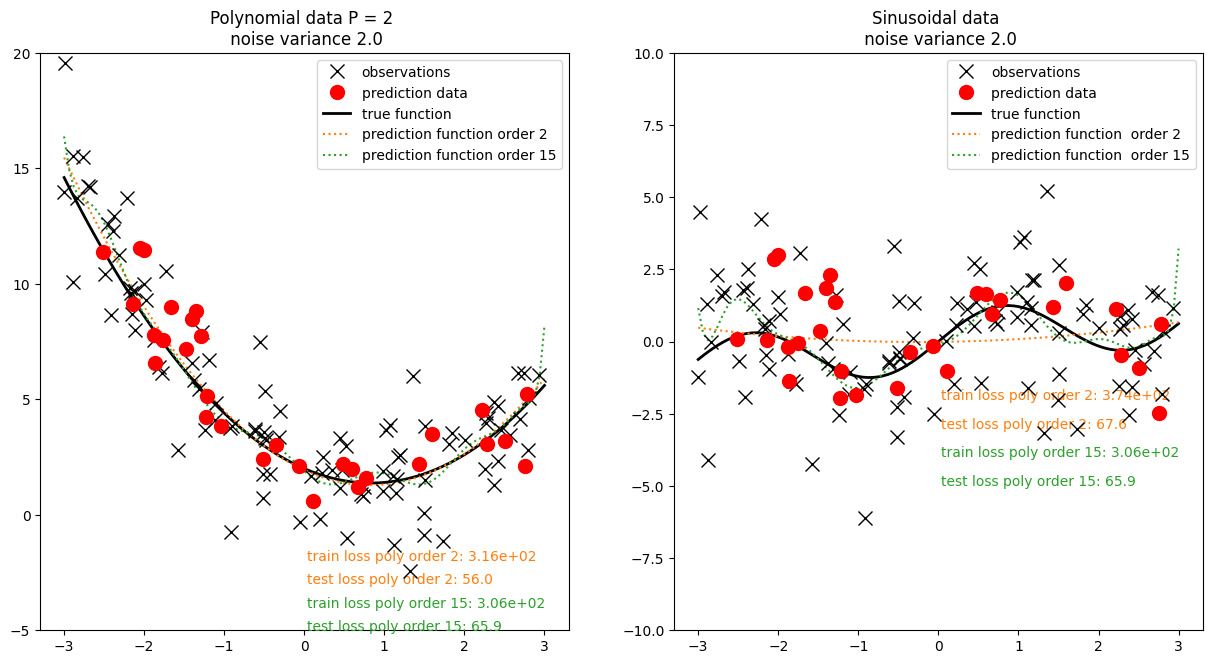

In [10]:
## Dataset generation
xmin = -3
xmax = 3
noise_var = 2.0
N_points = 100
N_test = 30

# polinomial data
poly_degree = 2
X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)
X_test_poly, t_test_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_test, seed = 5)

# sinusoidal data
frequency = 2
X_train_sinu, t_train_sinu = generate_sinusoidal_data(xmin, xmax, frequency, noise_var, N_points, seed = 1)
X_test_sinu, t_test_sinu = generate_sinusoidal_data(xmin, xmax, frequency, noise_var, N_test, seed = 5)

# plot function
xmin = -3
xmax = 3
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# true functions
y_grid_poly = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )
y_grid_sinu = sinusoidal_fun(x_grid, frequency = frequency)

## plot data and true model
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,7.5))

ax1.plot(X_train_poly, t_train_poly , 'x', color = 'k', label = 'observations', markersize = 10, zorder = 200)
ax1.plot(X_test_poly, t_test_poly , 'o', color = 'red', label = 'prediction data', markersize = 10, zorder = 200)
ax1.plot(x_grid, y_grid_poly, color = 'k', label = 'true function', linewidth = 2)
ax1.set_title(f'Polynomial data P = {poly_degree} \n noise variance {noise_var}')
ax1.legend()


ax2.plot(X_train_sinu, t_train_sinu , 'x', color = 'k', label = 'observations', markersize = 10, zorder = 200)
ax2.plot(X_test_sinu, t_test_sinu , 'o', color = 'red', label = 'prediction data', markersize = 10, zorder = 200)
ax2.plot(x_grid, y_grid_sinu, color = 'k', label = 'true function', linewidth = 2)
ax2.set_title(f'Sinusoidal data \n noise variance {noise_var}')
ax2.legend()

for i,poly_order in enumerate([2,15]):

    ## generate polynomial features
    X_feat_train_poly = generate_features(X_train_poly, poly_order)
    X_feat_train_sinu = generate_features(X_train_sinu, poly_order)
    X_feat_test_poly = generate_features(X_test_poly, poly_order)
    X_feat_test_sinu = generate_features(X_test_sinu, poly_order)
    X_feat_grid = generate_features(x_grid, poly_order)

    # fit model to polynomial data
    w_opt_poly = fit_norm2_least_square( X_feat_train_poly , t_train_poly )

    # fit model to sinusoidal data
    w_opt_sinu = fit_norm2_least_square( X_feat_train_sinu, t_train_sinu )


    # draw function on fitted model
    y_grid_poly = computation_graph_linear(  
                                           X_feat_grid, 
                                           w_opt_poly ,
                                           b = 0 ,
                                        )

    y_grid_sinu = computation_graph_linear(  
                                       X_feat_grid, 
                                       w_opt_sinu ,
                                       b = 0 ,
                                    )
    
    ## predictions on train and test set
    y_pred_train_poly = computation_graph_linear(  
                                                   X_feat_train_poly, 
                                                   w_opt_poly ,
                                                   b = 0 ,
                                                )
    
    y_pred_train_sinu = computation_graph_linear(  
                                                   X_feat_train_sinu, 
                                                   w_opt_sinu ,
                                                   b = 0 ,
                                                )

    y_pred_test_poly = computation_graph_linear(  
                                                   X_feat_test_poly, 
                                                   w_opt_poly ,
                                                   b = 0 ,
                                                )
    
    y_pred_test_sinu = computation_graph_linear(  
                                                   X_feat_test_sinu, 
                                                   w_opt_sinu ,
                                                   b = 0 ,
                                                )
    

    ## compute loss on the train and test sets
    loss_train_poly = np.sum(squared_loss_function( y_pred_train_poly, t_train_poly ))
    loss_train_sinu = np.sum(squared_loss_function( y_pred_train_sinu, t_train_sinu ))
    
    loss_test_poly = np.sum(squared_loss_function( y_pred_test_poly, t_test_poly ))
    loss_test_sinu = np.sum(squared_loss_function( y_pred_test_sinu, t_test_sinu ))
    
    ## plotting
    ax1.plot(x_grid, y_grid_poly, ':' , color = f'C{i+1}', label = f'prediction function order {poly_order}')
    ax1.text(x_grid[-50],-2 -2*i, f'train loss poly order {poly_order}: {loss_train_poly:.3}', color = f'C{i+1}')
    ax1.text(x_grid[-50],-2 -2*(i+1)+1, f'test loss poly order {poly_order}: {loss_test_poly:.3}', color = f'C{i+1}')
    ax1.set_ylim([-5,20])
    ax1.legend()

    ax2.plot(x_grid, y_grid_sinu, ':' , color = f'C{i+1}', label = f'prediction function  order {poly_order}')
    ax2.text(x_grid[-50],-2 -2*i, f'train loss poly order {poly_order}: {loss_train_sinu:.3}', color = f'C{i+1}')
    ax2.text(x_grid[-50],-2 -2*(i+1)+1, f'test loss poly order {poly_order}: {loss_test_sinu:.3}', color = f'C{i+1}')
    ax2.set_ylim([-10,10])
    ax2.legend()

However, extrapolating to regions where we did not observe data this kind of models do not work well. Bayesian approaches usually solve this problem on out of distribution regions. The best you can do when taking predictions is say you don't know when you actually don't know.

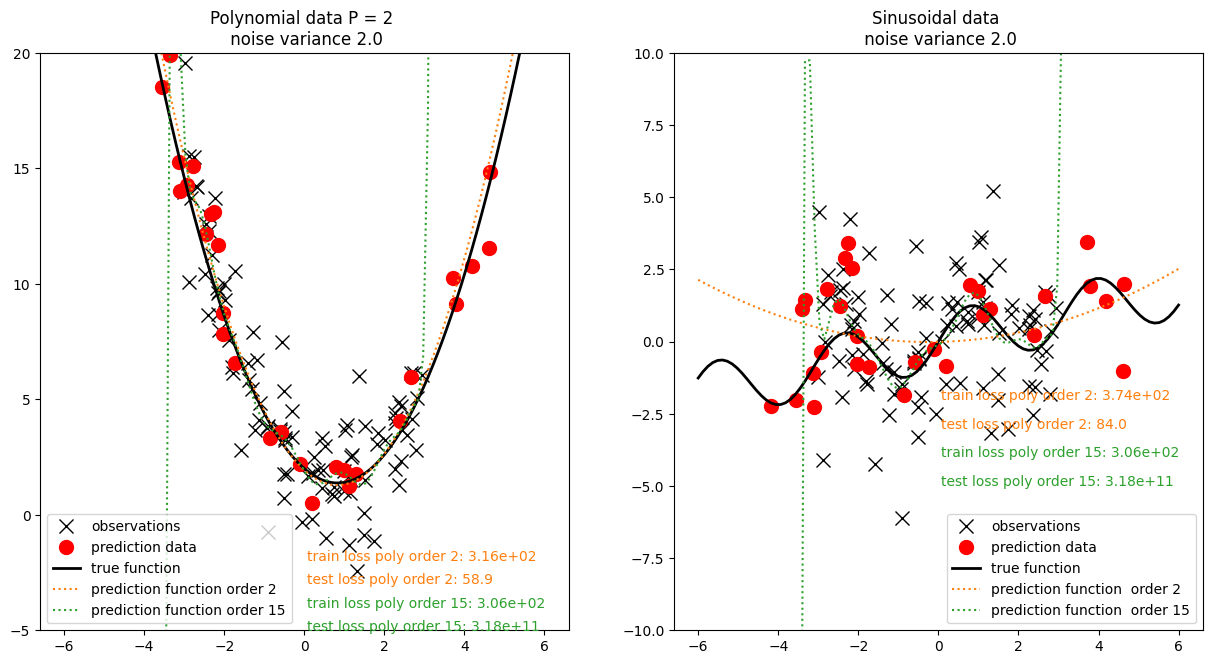

In [11]:
## Dataset generation
xmin = -3
xmax = 3
xmin_test = -5
xmax_test = 5
noise_var = 2.0
N_points = 100
N_test = 30

# polinomial data
poly_degree = 2
X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)
X_test_poly, t_test_poly = generate_polinomial_data(xmin_test, xmax_test, poly_degree, noise_var, N_test, seed = 5)

# sinusoidal data
frequency = 2
X_train_sinu, t_train_sinu = generate_sinusoidal_data(xmin, xmax, frequency, noise_var, N_points, seed = 1)
X_test_sinu, t_test_sinu = generate_sinusoidal_data(xmin_test, xmax_test, frequency, noise_var, N_test, seed = 5)

# plot function
xmin = -6
xmax = 6
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# true functions
y_grid_poly = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )
y_grid_sinu = sinusoidal_fun(x_grid, frequency = frequency)

## plot data and true model
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,7.5))

ax1.plot(X_train_poly, t_train_poly , 'x', color = 'k', label = 'observations', markersize = 10, zorder = -200)
ax1.plot(X_test_poly, t_test_poly , 'o', color = 'red', label = 'prediction data', markersize = 10, zorder = -200)
ax1.plot(x_grid, y_grid_poly, color = 'k', label = 'true function', linewidth = 2)
ax1.set_title(f'Polynomial data P = {poly_degree} \n noise variance {noise_var}')
ax1.legend()


ax2.plot(X_train_sinu, t_train_sinu , 'x', color = 'k', label = 'observations', markersize = 10, zorder = -200)
ax2.plot(X_test_sinu, t_test_sinu , 'o', color = 'red', label = 'prediction data', markersize = 10, zorder = -200)
ax2.plot(x_grid, y_grid_sinu, color = 'k', label = 'true function', linewidth = 2)
ax2.set_title(f'Sinusoidal data \n noise variance {noise_var}')
ax2.legend()

for i,poly_order in enumerate([2,15]):

    ## generate polynomial features
    X_feat_train_poly = generate_features(X_train_poly, poly_order)
    X_feat_train_sinu = generate_features(X_train_sinu, poly_order)
    X_feat_test_poly = generate_features(X_test_poly, poly_order)
    X_feat_test_sinu = generate_features(X_test_sinu, poly_order)
    X_feat_grid = generate_features(x_grid, poly_order)

    # fit model to polynomial data
    w_opt_poly = fit_norm2_least_square( X_feat_train_poly , t_train_poly )

    # fit model to sinusoidal data
    w_opt_sinu = fit_norm2_least_square( X_feat_train_sinu, t_train_sinu )


    # draw function on fitted model
    y_grid_poly = computation_graph_linear(  
                                           X_feat_grid, 
                                           w_opt_poly ,
                                           b = 0 ,
                                        )

    y_grid_sinu = computation_graph_linear(  
                                       X_feat_grid, 
                                       w_opt_sinu ,
                                       b = 0 ,
                                    )
    
    ## predictions on train and test set
    y_pred_train_poly = computation_graph_linear(  
                                                   X_feat_train_poly, 
                                                   w_opt_poly ,
                                                   b = 0 ,
                                                )
    
    y_pred_train_sinu = computation_graph_linear(  
                                                   X_feat_train_sinu, 
                                                   w_opt_sinu ,
                                                   b = 0 ,
                                                )

    y_pred_test_poly = computation_graph_linear(  
                                                   X_feat_test_poly, 
                                                   w_opt_poly ,
                                                   b = 0 ,
                                                )
    
    y_pred_test_sinu = computation_graph_linear(  
                                                   X_feat_test_sinu, 
                                                   w_opt_sinu ,
                                                   b = 0 ,
                                                )
    

    ## compute loss on the train and test sets
    loss_train_poly = np.sum(squared_loss_function( y_pred_train_poly, t_train_poly ))
    loss_train_sinu = np.sum(squared_loss_function( y_pred_train_sinu, t_train_sinu ))
    
    loss_test_poly = np.sum(squared_loss_function( y_pred_test_poly, t_test_poly ))
    loss_test_sinu = np.sum(squared_loss_function( y_pred_test_sinu, t_test_sinu ))
    
    ## plotting
    ax1.plot(x_grid, y_grid_poly, ":" , color = f'C{i+1}', label = f'prediction function order {poly_order}')
    ax1.text(x_grid[-50],-2 -2*i, f'train loss poly order {poly_order}: {loss_train_poly:.3}', color = f'C{i+1}')
    ax1.text(x_grid[-50],-2 -2*(i+1)+1, f'test loss poly order {poly_order}: {loss_test_poly:.3}', color = f'C{i+1}')
    ax1.set_ylim([-5,20])
    ax1.legend()

    ax2.plot(x_grid, y_grid_sinu, ":" , color = f'C{i+1}', label = f'prediction function  order {poly_order}')
    ax2.text(x_grid[-50],-2 -2*i, f'train loss poly order {poly_order}: {loss_train_sinu:.3}', color = f'C{i+1}')
    ax2.text(x_grid[-50],-2 -2*(i+1)+1, f'test loss poly order {poly_order}: {loss_test_sinu:.3}', color = f'C{i+1}')
    ax2.set_ylim([-10,10])
    ax2.legend()

We see error going up since we have generated test data beyond the limits where the training was created. More expressive models fail here. 

#### Underfitting

Underfitting can be easily shown by fitting a linear model to this data, when compared to a polynomial of order 2.

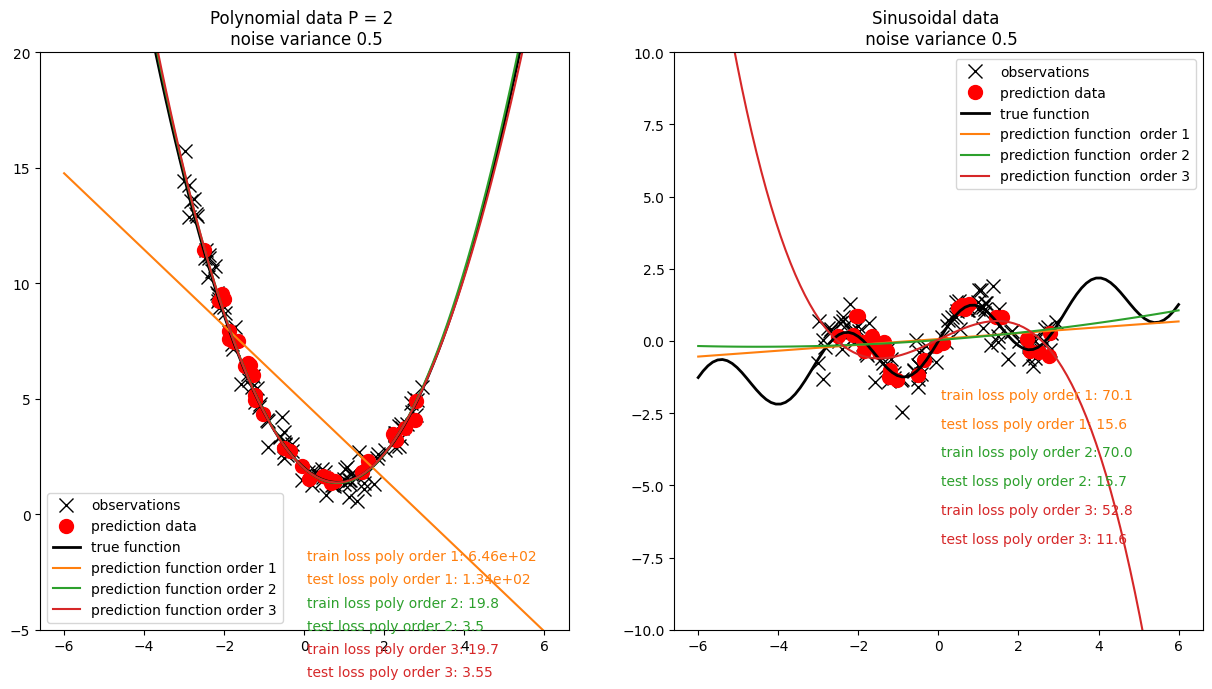

In [12]:
## Dataset generation
xmin = -3
xmax = 3
xmin_test = -3
xmax_test = 3
noise_var = 0.5
N_points = 100
N_test = 30

# polinomial data
poly_degree = 2
X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)
X_test_poly, t_test_poly = generate_polinomial_data(xmin_test, xmax_test, poly_degree, noise_var, N_test, seed = 5)

# sinusoidal data
frequency = 2
X_train_sinu, t_train_sinu = generate_sinusoidal_data(xmin, xmax, frequency, noise_var, N_points, seed = 1)
X_test_sinu, t_test_sinu = generate_sinusoidal_data(xmin_test, xmax_test, frequency, noise_var, N_test, seed = 5)

# plot function
xmin = -6
xmax = 6
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# true functions
y_grid_poly = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )
y_grid_sinu = sinusoidal_fun(x_grid, frequency = frequency)

## plot data and true model
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,7.5))

ax1.plot(X_train_poly, t_train_poly , 'x', color = 'k', label = 'observations', markersize = 10, zorder = -200)
ax1.plot(X_test_poly, t_test_poly , 'o', color = 'red', label = 'prediction data', markersize = 10, zorder = -200)
ax1.plot(x_grid, y_grid_poly, color = 'k', label = 'true function', linewidth = 2)
ax1.set_title(f'Polynomial data P = {poly_degree} \n noise variance {noise_var}')
ax1.legend()


ax2.plot(X_train_sinu, t_train_sinu , 'x', color = 'k', label = 'observations', markersize = 10, zorder = -200)
ax2.plot(X_test_sinu, t_test_sinu , 'o', color = 'red', label = 'prediction data', markersize = 10, zorder = -200)
ax2.plot(x_grid, y_grid_sinu, color = 'k', label = 'true function', linewidth = 2)
ax2.set_title(f'Sinusoidal data \n noise variance {noise_var}')
ax2.legend()

for i,poly_order in enumerate([1,2,3]):

    ## generate polynomial features
    X_feat_train_poly = generate_features(X_train_poly, poly_order)
    X_feat_train_sinu = generate_features(X_train_sinu, poly_order)
    X_feat_test_poly = generate_features(X_test_poly, poly_order)
    X_feat_test_sinu = generate_features(X_test_sinu, poly_order)
    X_feat_grid = generate_features(x_grid, poly_order)

    # fit model to polynomial data
    w_opt_poly = fit_norm2_least_square( X_feat_train_poly , t_train_poly )

    # fit model to sinusoidal data
    w_opt_sinu = fit_norm2_least_square( X_feat_train_sinu, t_train_sinu )


    # draw function on fitted model
    y_grid_poly = computation_graph_linear(  
                                           X_feat_grid, 
                                           w_opt_poly ,
                                           b = 0 ,
                                        )

    y_grid_sinu = computation_graph_linear(  
                                       X_feat_grid, 
                                       w_opt_sinu ,
                                       b = 0 ,
                                    )
    
    ## predictions on train and test set
    y_pred_train_poly = computation_graph_linear(  
                                                   X_feat_train_poly, 
                                                   w_opt_poly ,
                                                   b = 0 ,
                                                )
    
    y_pred_train_sinu = computation_graph_linear(  
                                                   X_feat_train_sinu, 
                                                   w_opt_sinu ,
                                                   b = 0 ,
                                                )

    y_pred_test_poly = computation_graph_linear(  
                                                   X_feat_test_poly, 
                                                   w_opt_poly ,
                                                   b = 0 ,
                                                )
    
    y_pred_test_sinu = computation_graph_linear(  
                                                   X_feat_test_sinu, 
                                                   w_opt_sinu ,
                                                   b = 0 ,
                                                )
    

    ## compute loss on the train and test sets
    loss_train_poly = np.sum(squared_loss_function( y_pred_train_poly, t_train_poly ))
    loss_train_sinu = np.sum(squared_loss_function( y_pred_train_sinu, t_train_sinu ))
    
    loss_test_poly = np.sum(squared_loss_function( y_pred_test_poly, t_test_poly ))
    loss_test_sinu = np.sum(squared_loss_function( y_pred_test_sinu, t_test_sinu ))
    
    ## plotting
    ax1.plot(x_grid, y_grid_poly , color = f'C{i+1}', label = f'prediction function order {poly_order}')
    ax1.text(x_grid[-50],-2 -2*i, f'train loss poly order {poly_order}: {loss_train_poly:.3}', color = f'C{i+1}')
    ax1.text(x_grid[-50],-2 -2*(i+1)+1, f'test loss poly order {poly_order}: {loss_test_poly:.3}', color = f'C{i+1}')
    ax1.set_ylim([-5,20])
    ax1.legend()

    ax2.plot(x_grid, y_grid_sinu , color = f'C{i+1}', label = f'prediction function  order {poly_order}')
    ax2.text(x_grid[-50],-2 -2*i, f'train loss poly order {poly_order}: {loss_train_sinu:.3}', color = f'C{i+1}')
    ax2.text(x_grid[-50],-2 -2*(i+1)+1, f'test loss poly order {poly_order}: {loss_test_sinu:.3}', color = f'C{i+1}')
    ax2.set_ylim([-10,10])
    ax2.legend()

## Regularization

The concept of regularization refers to how can we modify the learning process in a way that generalization is improved, ie, that we encourage the model not to learning the data but the underlying generating process.

There are many ways in which a model can be regularized: from the data view point (data augmentation for example), modifying the model by changing its inductive bias or reducing/augmenting its expresivness, or by changing the underlying loss function either by setting a different observation model or placing regularizers on the parameters through a prior distribution. This is the case we will see.

The idea is to restrict the model parameters to lie within a ball of whatever radius. This ball is defined through a norm and we will consider the $L_2$ and $L_1$ norm. We can visualize the set of points that are plausible for the model parameters to lie in depending on the norm defining the ball.

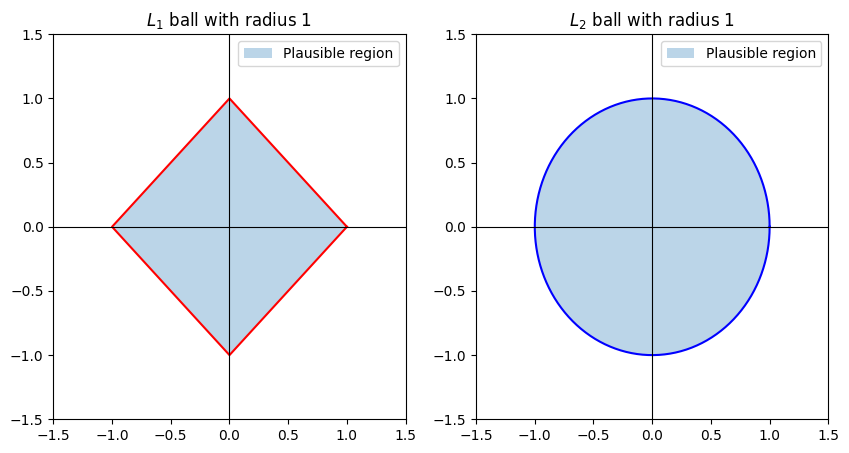

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))

## Radio
r = 1  

# L1
x_L1 = [ r, 0, -r, 0,  r]
y_L1 = [ 0, r,  0, -r, 0]

# L2
theta = np.linspace(0, 2*np.pi, 400)
x_L2 = r * np.cos(theta)
y_L2 = r * np.sin(theta)

## Dibujar bolas
ax1.plot(x_L1, y_L1, color="red")       
ax1.fill(x_L1, y_L1, alpha=0.3, label = "Plausible region")

ax2.plot(x_L2, y_L2, color="blue")       
ax2.fill(x_L2, y_L2, alpha=0.3, label = 'Plausible region')          

# Ejes
ax1.axhline(0, color="black", linewidth=0.8)
ax1.axvline(0, color="black", linewidth=0.8)
ax2.axhline(0, color="black", linewidth=0.8)
ax2.axvline(0, color="black", linewidth=0.8)

# Titulos
ax1.set_title(f"$L_1$ ball with radius {r}")
ax2.set_title(f"$L_2$ ball with radius {r}")

# Figura con aspecto cuadrado
ax1.set_xlim(-r-0.5, r+0.5)
ax1.set_ylim(-r-0.5, r+0.5)
ax2.set_xlim(-r-0.5, r+0.5)
ax2.set_ylim(-r-0.5, r+0.5)

ax1.legend()
ax2.legend()

### $L_2$ regularization

$$
\newcommand{\x}{\mathbf{x}}
\newcommand{\w}{\mathbf{w}}
\newcommand{\z}{\mathbf{z}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\t}{\mathbf{t}}
\newcommand{\Z}{\mathbf{Z}}
\newcommand{\Y}{\mathbf{Y}}
\newcommand{\X}{\mathbf{X}}
\newcommand{\W}{\mathbf{W}}
\newcommand{\T}{\mathbf{T}}
\newcommand{\I}{\mathbf{I}}
\newcommand{\J}{\mathbf{J}}
\newcommand{\dd}{\text{d}}
\newcommand{\vec}{\text{vec}}
$$

Restricting this parameter to lie within this ball can be done through a Lagrange multiplier. Note that any loss function, such as the quadratic loss can be modified in such a way to satisfy this restriction. In particular the modified loss can be written down as:

\begin{split}
L(\X,\T,\W) = ||(\T-\X\W)||^2_2; \text{  subject to  } ||\W||_2 \leq r
\end{split}

In practice, the loss being minimized is given by:

\begin{split}
L(\X,\T,\W) = ||(\T-\X\W)||^2_2 + \lambda ||\W||^2_2
\end{split}


Up to this moment I haven't workout how to reach this loss function from the above restriction. However, it can be easily see how this loss impose the restriction. First, note that instead of using the norm, we are using the square of the norm. Since the norm is possitive, the square of the norm is a monotonic function and thus it will not change the order of points with decreasing/incresing norm.

So adding this term to a minimization process will force the norm of the model to be small. The hyperparameter $\lambda$ controls how restrictive we are. Big values for $\lambda$ will encourage the norm to be big and thus the parameters will be force to be small in order to minimize the norm. Note that this regularization, by itself, is minimized when all the weights are $0$. However, the other part of the loss function encourages the parameters to fit the data and so minimizing this loss function is a trade-off between explaining the data and making the weights small.

The next question is why this avoids overfitting?. Well if we force the parameters of the models to be small, then none of the dimensions of the problem might dominate over the others, or at least there is no freedom to make a parameter arbitrary big wrt the others, although relatively we can still have weights that dominate over the others. This makes that high order polynomials, for example, will have it "hard" to generate wiggle functions. We will discuss further on this.

With $L_2$ regularization we can obtain optimal solution for the parameters. Since the regularization term is added to the data fit term, we just need to workout the differential on this term and then sum it with the other. In this case, no chain rule is necessary. Again writting the Frobenius norm through traces we have:

\begin{split}
\dd \lambda ||\W||^2_2 &= \dd \lambda\text{Tr}[\W^T\W]\\
&= \lambda \text{Tr}[ \dd \W^T\W + \W^T \dd \W] \\
&= \lambda \text{Tr}[ \W^T\dd\W + \W^T \dd \W] \\
&= 2\lambda \text{Tr}[\W^T \dd \W] \\
&= 2\lambda [\vec{\W}]^T \dd\vec\W
\end{split}

from where the Jacobian is given by $2\lambda [\vec{\W}]^T$. The corresponding gradient is just the transpose and so $2\lambda [\vec{\W}]$.

We can now add this term to our previous gradient and set to zero. 

\begin{split}
-2 [\I \otimes \X^T]\vec[\T - \X\W] + 2\lambda [\vec{\W}]&= 0\\
[\I \otimes \X^T]\vec[\T] - [\I \otimes \X^T]\vec[\X\W\I]+ \lambda [\vec{\W}]&= 0\\
[\I \otimes \X^T]\vec[\T] - [\I \otimes \X^T](\I\otimes\X)\vec[\W] + \lambda [\vec{\W}] &= 0\\
[\I \otimes \X^T]\vec[\T] - [\I \otimes \X^T\X]\vec[\W]+ \lambda [\vec{\W}] &= 0\\
[\I \otimes \X^T]\vec[\T]  &= [\I \otimes \X^T\X]\vec[\W] - \lambda [\vec{\W}]\\
\left([\I \otimes \X^T\X]- \lambda \I\right)^{-1}[\I \otimes \X^T]\vec[\T]  &= \vec[\W]\\
[\I \otimes (\X^T\X - \lambda \I)^{-1}][\I \otimes \X^T]\vec[\T]  &= \vec[\W]\\
[\I \otimes (\X^T\X- \lambda \I)^{-1}\X^T]\vec[\T]  &= \vec[\W]\\
\vec[(\X^T\X- \lambda \I)^{-1}\X^T\T\I]  &= \vec[\W]\\
\vec[(\X^T\X- \lambda \I)^{-1}\X^T\T]  &= \vec[\W]
\end{split}

from where:

\begin{split}
\W^* = (\X^T\X- \lambda \I)^{-1}\X^T\T
\end{split}

Obviously for one dimendional multivariate regression $f:\mathbb{R}^N \to \mathbb{R}$ the derivation is simpler because the vec operator and kronecker products do not take part of the derivation. **Exercise**.

Let's visualize the effect of the regularizer.

/tmp/ipykernel_2213895/4157521109.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Lambda {lam} poly order {poly_order} weights {[f'{float(w):.4f}' for w in w_opt_poly]}")


Lambda 0.0 poly order 2 weights ['1.8708', '-1.6167', '0.9045']
Lambda 0.0 poly order 8 weights ['1.2035', '-2.1437', '2.8672', '-0.0069', '-1.1082', '0.0533', '0.2058', '-0.0055', '-0.0120']
Lambda 0.0 poly order 20 weights ['3.1907', '-14.2636', '-6.0223', '106.0932', '18.2349', '-287.5100', '-29.5620', '362.3016', '37.6032', '-247.7282', '-31.5988', '98.8136', '15.4271', '-23.5894', '-4.3201', '3.3124', '0.6851', '-0.2518', '-0.0572', '0.0080', '0.0019']
----------------------------
Lambda 10 poly order 2 weights ['1.0826', '-1.4674', '1.0469']
Lambda 10 poly order 8 weights ['1.1081', '-0.7870', '0.6931', '-0.4471', '0.2304', '0.0710', '-0.0439', '-0.0032', '0.0025']
Lambda 10 poly order 20 weights ['0.9972', '-0.6515', '0.5967', '-0.4353', '0.4247', '-0.3097', '0.2398', '-0.1307', '-0.0011', '0.0960', '-0.1317', '0.1472', '0.0805', '-0.1167', '-0.0317', '0.0318', '0.0077', '-0.0038', '-0.0009', '0.0002', '0.0000']
----------------------------


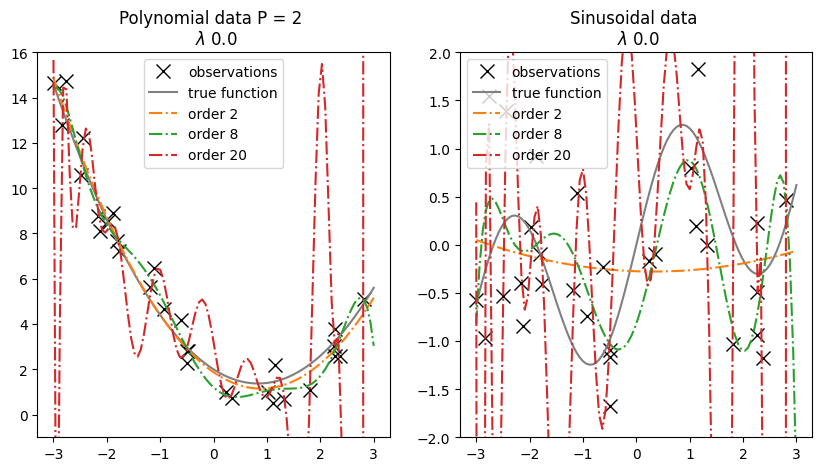

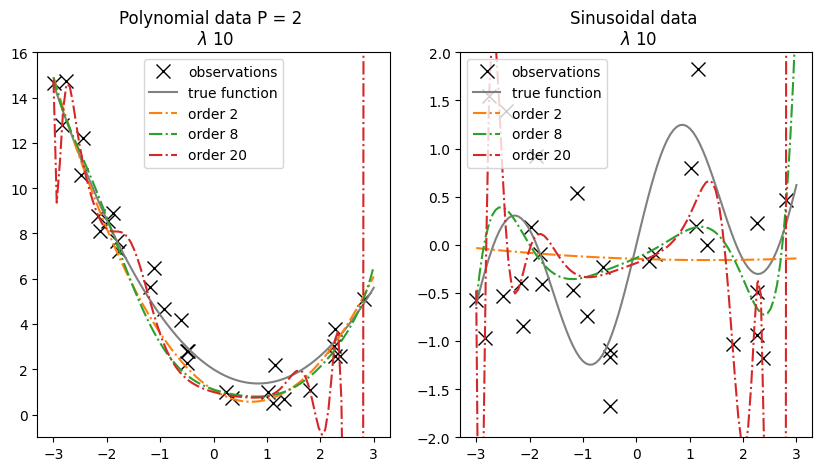

In [14]:
%matplotlib inline
plt.close("all")

## Dataset generation
xmin = -3
xmax = 3
noise_var = 1
N_points = 30

# polinomial data
poly_degree = 2
X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)

# sinusoidal data
frequency = 2
X_train_sinu, t_train_sinu = generate_sinusoidal_data(xmin, xmax, frequency, noise_var, N_points, seed = 1)

# plot function
xmin = -3
xmax = 3
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# true functions
y_grid_poly_true = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )
y_grid_sinu_true = sinusoidal_fun(x_grid, frequency = frequency)

for lam in [0.0,10]:

    ## plot data and true model
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))

    ax1.plot(X_train_poly, t_train_poly , 'x', color = 'k', label = 'observations', markersize = 10)
    ax1.plot(x_grid, y_grid_poly_true, color = 'gray', label = 'true function')
    ax1.set_title(f'Polynomial data P = {poly_degree} \n $\lambda$ {lam}')
    ax1.legend()


    ax2.plot(X_train_sinu, t_train_sinu , 'x', color = 'k', label = 'observations', markersize = 10)
    ax2.plot(x_grid, y_grid_sinu_true, color = 'gray', label = 'true function')
    ax2.set_title(f'Sinusoidal data \n $\lambda$ {lam}')
    ax2.legend()

    for i,poly_order in enumerate([2,8,20]):

        ## generate polynomial features
        X_feat_poly = generate_features(X_train_poly, poly_order)
        X_feat_sinu = generate_features(X_train_sinu, poly_order)
        X_feat_grid = generate_features(x_grid, poly_order)

        # fit model to polynomial data
        w_opt_poly = fit_norm2_least_square( X_feat_poly , t_train_poly, lam = lam )

        # fit model to sinusoidal data
        w_opt_sinu = fit_norm2_least_square( X_feat_sinu, t_train_sinu, lam = lam )


        # draw function on fitted model
        y_grid_poly = computation_graph_linear(  
                                               X_feat_grid, 
                                               w_opt_poly ,
                                               b = 0 ,
                                            )

        y_grid_sinu = computation_graph_linear(  
                                           X_feat_grid, 
                                           w_opt_sinu ,
                                           b = 0 ,
                                        )

        ## plotting
        ax1.plot(x_grid, y_grid_poly,'-.' , color = f'C{i+1}', label = f'order {poly_order}')
        ax1.set_ylim([-1,16])
        ax1.legend()

        ax2.plot(x_grid, y_grid_sinu,'-.' , color = f'C{i+1}', label = f'order {poly_order}')
        ax2.set_ylim([-2,2])
        ax2.legend()
        
        print(f"Lambda {lam} poly order {poly_order} weights {[f'{float(w):.4f}' for w in w_opt_poly]}")
    print("----------------------------")

We see how by encouraging the weights to have small norm, high level features might be relaxed and overtiffing is reduced. Obviously, grabbing more data reduces the effect further.

/tmp/ipykernel_2213895/2315030543.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Lambda {lam} poly order {poly_order} weights {[f'{float(w):.4f}' for w in w_opt_poly]}")


Lambda 0.0 poly order 2 weights ['1.9681', '-1.5475', '0.9357']
Lambda 0.0 poly order 8 weights ['2.1036', '-1.4770', '0.6383', '0.0183', '0.1224', '-0.0115', '-0.0183', '0.0010', '0.0009']
Lambda 0.0 poly order 20 weights ['1.6483', '-2.1986', '7.4773', '2.5885', '-25.4969', '-1.7485', '38.5507', '-0.4524', '-29.5290', '0.8893', '12.9180', '-0.3899', '-3.4202', '0.0850', '0.5577', '-0.0102', '-0.0547', '0.0006', '0.0030', '-0.0000', '-0.0001']
----------------------------
Lambda 10 poly order 2 weights ['1.6290', '-1.4958', '0.9935']
Lambda 10 poly order 8 weights ['1.6532', '-0.8092', '0.6875', '-0.3960', '0.2089', '0.0655', '-0.0405', '-0.0034', '0.0023']
Lambda 10 poly order 20 weights ['1.6151', '-0.6970', '0.6241', '-0.2908', '0.3311', '-0.1452', '0.1129', '-0.0321', '-0.0799', '0.0409', '-0.0748', '0.0095', '0.0652', '-0.0095', '-0.0198', '0.0021', '0.0030', '-0.0002', '-0.0002', '0.0000', '0.0000']
----------------------------


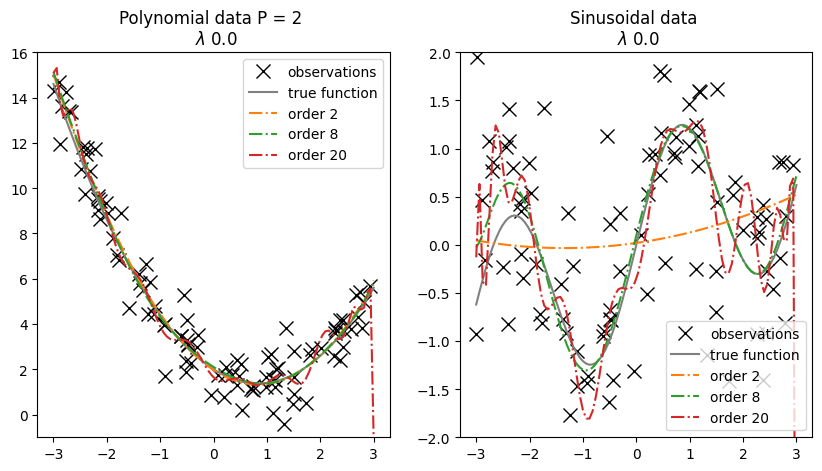

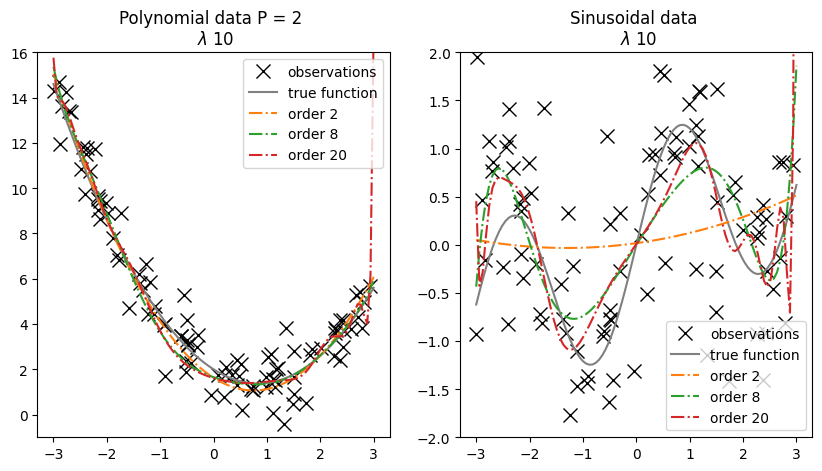

In [15]:
%matplotlib inline
plt.close("all")

## Dataset generation
xmin = -3
xmax = 3
noise_var = 1
N_points = 100

# polinomial data
poly_degree = 2
X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)

# sinusoidal data
frequency = 2
X_train_sinu, t_train_sinu = generate_sinusoidal_data(xmin, xmax, frequency, noise_var, N_points, seed = 1)

# plot function
xmin = -3
xmax = 3
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# true functions
y_grid_poly_true = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )
y_grid_sinu_true = sinusoidal_fun(x_grid, frequency = frequency)

for lam in [0.0,10]:

    ## plot data and true model
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))

    ax1.plot(X_train_poly, t_train_poly , 'x', color = 'k', label = 'observations', markersize = 10)
    ax1.plot(x_grid, y_grid_poly_true, color = 'gray', label = 'true function')
    ax1.set_title(f'Polynomial data P = {poly_degree} \n $\lambda$ {lam}')
    ax1.legend()


    ax2.plot(X_train_sinu, t_train_sinu , 'x', color = 'k', label = 'observations', markersize = 10)
    ax2.plot(x_grid, y_grid_sinu_true, color = 'gray', label = 'true function')
    ax2.set_title(f'Sinusoidal data \n $\lambda$ {lam}')
    ax2.legend()

    for i,poly_order in enumerate([2,8,20]):

        ## generate polynomial features
        X_feat_poly = generate_features(X_train_poly, poly_order)
        X_feat_sinu = generate_features(X_train_sinu, poly_order)
        X_feat_grid = generate_features(x_grid, poly_order)

        # fit model to polynomial data
        w_opt_poly = fit_norm2_least_square( X_feat_poly , t_train_poly, lam = lam )

        # fit model to sinusoidal data
        w_opt_sinu = fit_norm2_least_square( X_feat_sinu, t_train_sinu, lam = lam )


        # draw function on fitted model
        y_grid_poly = computation_graph_linear(  
                                               X_feat_grid, 
                                               w_opt_poly ,
                                               b = 0 ,
                                            )

        y_grid_sinu = computation_graph_linear(  
                                           X_feat_grid, 
                                           w_opt_sinu ,
                                           b = 0 ,
                                        )

        ## plotting
        ax1.plot(x_grid, y_grid_poly,'-.' , color = f'C{i+1}', label = f'order {poly_order}')
        ax1.set_ylim([-1,16])
        ax1.legend()

        ax2.plot(x_grid, y_grid_sinu,'-.' , color = f'C{i+1}', label = f'order {poly_order}')
        ax2.set_ylim([-2,2])
        ax2.legend()
        
        print(f"Lambda {lam} poly order {poly_order} weights {[f'{float(w):.4f}' for w in w_opt_poly]}")
    print("----------------------------")

### Feature normalization


While normalization deserves its own chapter in the context of parameter regularization and optimization convergence, it can help understand why it is also important for a good convergence and learning of the model. Normalization is the process of getting some features and put them within the same range. Overall, it helps the learning process, and also make the model let's prone to overfitting. Polynomial regression is an easy example of why.

Consider the linear combination implemented by a linear model:

\begin{split}
    y = w_0 + w_1x_1 + w_2x_2 + w_3x_3 + w_4x_4
\end{split}

what would happen if the scale of $x_4$ is much bigger than that of $x_1$?. This would imply that the linear combination is dominated by $x_4$ feature. If the relative importance is not so high, learning to adapt the rest of the weights will take time. Moreover over the gradient scale will have a different impact on the learning process, and so vanilla gradient descent will fail to successfully train "fast". Moreover, if for whatever reason a high value of this feature encourages the model to learn some part of the data better, then the model can get stuck on making this contribution bigger, ending up in overfitting. This is, in fact, what happens in polynomial regression, since here we have:


\begin{split}
    y = w_0 + w_1x + w_2x^2 + w_3x^3 + w_4x^4
\end{split}

Since $x^4$ is much bigger than $x$, then its contribution is bigger. This implies that at the beginning of the learning process, the model is prone to model high-order features, which are wavy and can learn to fit the data easily. Even a regularized model that makes the weights go to zero, will get stuck. Why? because even a small value for $w_4$ can be manifested as a huge contribution to $y$ due to $x^4$ being bigger than, for example $x$; so even if the regularizer makes $w_4$ go to $0$ the effect will not disappear, because this reduction in magnitude will be compensated by $x^4$. At the same time the rest of coefficients will be made small by the regularizer, and the overall contribution will be given by  $x^4$. To avoid this, we can just normalize the data by subtracting the mean and dividing by the standard deviation. Let's compare the behaviour of regularized and non-regularized models, comparing data and non-data normalization.

In machine learning there are two options. For evaluation we can just normalize data and perform all computations on normalized space. For predictions, we usually normalize data, perform prediction, and unormalized the output. Since normalization is a linear operator, it will not change the shape of the function learnt. 

Moreover, it can be shown that without regularization, feature normalization is not relevant when optimizing a linear model through exact minimization via least squares with a $L_2$ norm. **Exercise**

Let's visualize the effect of training over normalized features. In this case we will be normalizing both targets $\t$ and features $\x$.

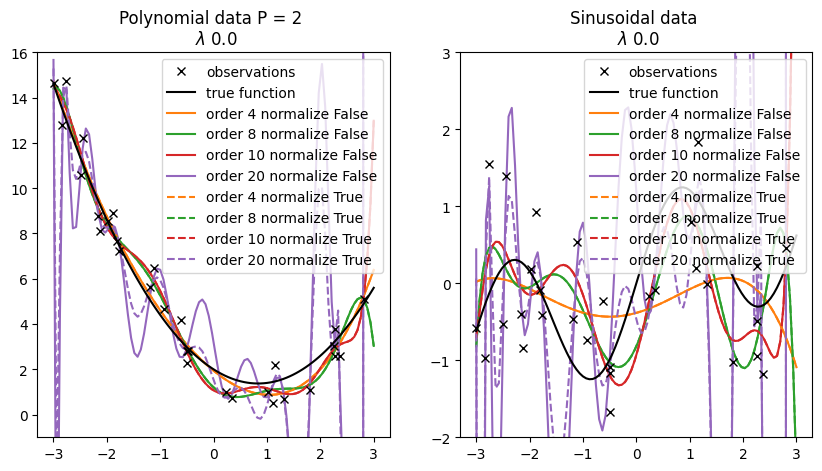

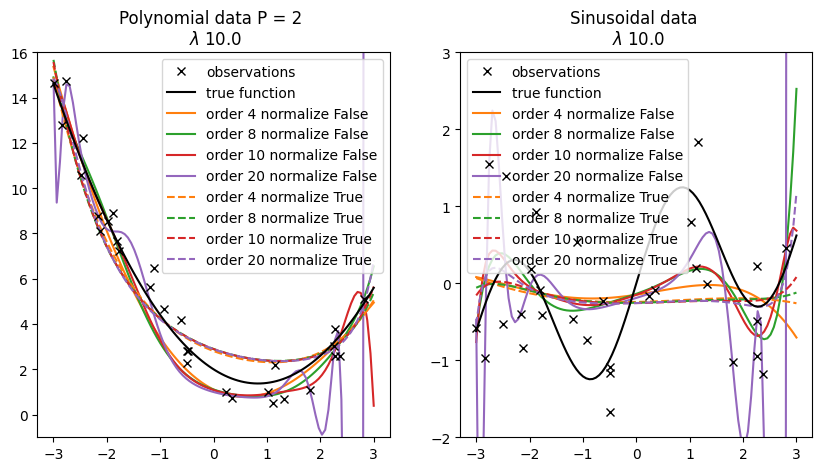

In [16]:
%matplotlib inline
plt.close("all")

## Dataset generation
xmin = -3
xmax = 3
noise_var = 1
N_points = 30

# polinomial data
poly_degree = 2
_X_train_poly, _t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)

# sinusoidal data
frequency = 2
_X_train_sinu, _t_train_sinu = generate_sinusoidal_data(xmin, xmax, frequency, noise_var, N_points, seed = 1)

# plot function
xmin = -3
xmax = 3
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# true functions
y_grid_poly_true = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )
y_grid_sinu_true = sinusoidal_fun(x_grid, frequency = frequency)

for lam in [0.0,10.0]:
    
    ## plot data and true model
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))

    ax1.plot(_X_train_poly, _t_train_poly , 'x', color = 'k', label = 'observations', zorder = 10)
    ax1.plot(x_grid, y_grid_poly_true, color = 'k', label = 'true function', zorder = 5)
    ax1.set_title(f'Polynomial data P = {poly_degree} \n $\lambda$ {lam}')
    ax1.legend()

    ax2.plot(_X_train_sinu, _t_train_sinu , 'x', color = 'k', label = 'observations', zorder = 10)
    ax2.plot(x_grid, y_grid_sinu_true, color = 'k', label = 'true function', zorder = 5)
    ax2.set_title(f'Sinusoidal data \n $\lambda$ {lam}')
    ax2.legend()
    
    for norm in [False,True]: 

        for i,poly_order in enumerate([4,8,10,20]):
            # grab original unormalized data
            X_train_poly, t_train_poly = copy.deepcopy(_X_train_poly), copy.deepcopy(_t_train_poly)
            X_train_sinu, t_train_sinu = copy.deepcopy(_X_train_sinu), copy.deepcopy(_t_train_sinu)

            
            ## generate polynomial features
            X_feat_poly = generate_features(X_train_poly, poly_order)
            X_feat_sinu = generate_features(X_train_sinu, poly_order)
            X_feat_grid_poly = generate_features(x_grid, poly_order)
            X_feat_grid_sinu = generate_features(x_grid, poly_order)
            
            if norm:
                # we normalize all but first column, which is a columns of ones.
                X_feat_poly, X_mean_poly, X_std_poly = norm_data(X_feat_poly[:,1:])
                X_feat_sinu, X_mean_sinu, X_std_sinu = norm_data(X_feat_sinu[:,1:])
                
                X_feat_grid_poly, _, _ = norm_data(X_feat_grid_poly[:,1:], mean = X_mean_poly, std = X_std_poly)
                X_feat_grid_sinu, _, _ = norm_data(X_feat_grid_sinu[:,1:], mean = X_mean_sinu, std = X_std_sinu)
                
                # concatenate back ones.
                X_feat_poly = np.hstack([np.ones((X_feat_poly.shape[0], 1)), X_feat_poly])
                X_feat_sinu = np.hstack([np.ones((X_feat_sinu.shape[0], 1)), X_feat_sinu])
                X_feat_grid_poly = np.hstack([np.ones((X_feat_grid_poly.shape[0], 1)), X_feat_grid_poly])
                X_feat_grid_sinu = np.hstack([np.ones((X_feat_grid_sinu.shape[0], 1)), X_feat_grid_sinu])
                
                t_train_poly, t_mean_poly, t_std_poly = norm_data(t_train_poly)
                t_train_sinu, t_mean_sinu, t_std_sinu = norm_data(t_train_sinu)
                
            # fit model to polynomial data
            w_opt_poly = fit_norm2_least_square( X_feat_poly , t_train_poly, lam = lam )

            # fit model to sinusoidal data
            w_opt_sinu = fit_norm2_least_square( X_feat_sinu, t_train_sinu, lam = lam )


            # draw function on fitted model
            y_grid_poly = computation_graph_linear(  
                                                   X_feat_grid_poly, 
                                                   w_opt_poly ,
                                                   b = 0 ,
                                                )

            y_grid_sinu = computation_graph_linear(  
                                               X_feat_grid_sinu, 
                                               w_opt_sinu ,
                                               b = 0 ,
                                            )
            # unormalize predictions
            if norm:
                y_grid_poly = y_grid_poly * t_std_poly + t_mean_poly
                y_grid_sinu = y_grid_sinu * t_std_sinu + t_mean_sinu
                
            linestyle = '-'
            if norm:
                linestyle = '--'

            ## plotting
            ax1.plot(x_grid, y_grid_poly , color = f'C{i+1}', linestyle = linestyle, label = f'order {poly_order} normalize {norm}')
            ax1.set_ylim([-1,16])
            ax1.legend()

            ax2.plot(x_grid, y_grid_sinu , color = f'C{i+1}', linestyle = linestyle, label = f'order {poly_order} normalize {norm}')
            ax2.set_ylim([-2,3])
            ax2.legend()


$$
\newcommand{\x}{\mathbf{x}}
\newcommand{\w}{\mathbf{w}}
\newcommand{\Z}{\mathbf{Z}}
\newcommand{\Y}{\mathbf{Y}}
\newcommand{\X}{\mathbf{X}}
\newcommand{\T}{\mathbf{T}}
$$

### $L_1$ regularization

$L_1$ regularization not only encourages the weight to be small, but also shrinks them to $0$. Thus, it is a way to perform automatic feature selection. For an intuitive description on why this happens, the following video is quite illustrative: https://www.youtube.com/watch?v=4qJrQ7DxAdk . Here is another interactive reference where you can have access to code to see why $L_1$ regularization has this behaviour: https://maitbayev.github.io/posts/why-l1-loss-encourage-coefficients-to-shrink-to-zero/

From the viewpoint of the Laplacian prior is quite understandable, because this prior distribution has a peak arround $0$. From a geometrical viewpoint the video is perhaps a better explanation that what can be done just writting. From the optimization view point gradient based optimization is very illustrative as well.

First of all note that the $L_1$ norm is non-differntiable at $0$, which implies that at this point we need to use the subgradient. In practice software such as pytorch just use the value $0$ for the subgradient at this point. This means that gradient descent on the $L_2$ and $L_1$ norm can be written as follows.

#### $L_2$

\begin{split}
\nabla L_w(\X,\T,\w) = -2\cdot\X ^T(\T - \X\w)+ 2 \lambda \w
\end{split}

which means gradient descent updates parameters as:

\begin{split}
\w_{t+1} = \w_t - \alpha \left[-\X ^T(\T - \X\w)+ \lambda \w\right]
\end{split}

where the factor $2$ is absorved by the learning rate. What do we observe here? Well the rate of convergence of the parameter $\w$ to zero decreases when the parameter itself is close to zero, because $\lambda \w$ is small and so the modification made to the parameter when this parameter is closed to $0$ is small. This means that when the parameter is closed to zero, the gradient update is dominated by the data dependent term.

#### $L_1$

With $L_1$ regularization things are different. Note that the loss function is now:

\begin{split}
L(\X,\T,\w) = ||(\T-\X\w)||^2_2; \text{  subject to  } ||\w||_1 \leq r
\end{split}

In practice, the loss being minimized is given by:

\begin{split}
L(\X,\T,\w) = ||(\T-\X\w)||^2_2 + \lambda ||\w||_1
\end{split}

Now the square is not taken, otherwise the regularization term would always be positive. The reason why we take square on the $L_2$ is for the gradient update to be constant (ie convexity with no change in curvature). Also not taking the square of the norm implies a singularity at $w=0$. Finally, no exact solution to the minimizatino problem is available. **Exercise**

Since the gradient of the norm $1$ is constant, and (commonly) defined by $0$ at $w=0$, then gradient updates are given by:

\begin{split}
\nabla L_w(\X,\T,\w) = -2\cdot\X^T(\T - \X\w)+ \lambda \text{sign}(\w)
\end{split}

which means gradient descent updates parameters as:

\begin{split}
\w_{t+1} = \w_t - \alpha \left[-2\cdot\X ^T(\T - \X\w)+ \lambda \text{sign}(\w)\right]
\end{split}

we see that how much $\w$ is modified by the regularization term does not depend on $\w$. It will always be the value $1$ of $-1$, pushing the parameter towards zero, without depending on its magnitude. This means that the regularization term pushes equally to $0$ any parameter at any moment of the optimization.

However, state of the art optimization of linear regression with $L_1$ regularization is done by a coordinate descent algorithm. This will allow us to introduce the skelarn library to fit this model.


#### Feature selection through $L_1$ regularization

Linear regresion with $L_1$ regularization is also knowns as Lasso. Since $L_1$ norm is non-differentiable at $x=0$, state of the art optimization of this model is based on coordinate descent. Gradient descent could be used using the concept of subgradient. In fact software as pytorch just define the derivative at $x=0$ to be zero, which is one of the possible values for the subgradient. Neverthless this is slower than using coordinate descent.

$L_1$ regularization is able to select features from within the data, this means, setting the coefficients to zero. For example if:

\begin{split}
y = b + w_1 \cdot x + w_2 \cdot x^2  + w_3 \cdot x^3
\end{split}

but our data is linear, then $L_1$ regularization can set the coefficients $w_2,w_3$ to zero. This is also known as shrinkage. 

Any loss function can be regularized through $L_1$ regularizaiton, since this is just a penalty we put on the parameters. For our polynomial regression model with squared loss we have:

\begin{split}
    L(t,x,w) = \sum^N_{n=1} \sum^K_{k=1} (t_n - (x_n^T)^k\cdot w_k)^2 + \sum^K_{k=1} \lambda_k || w_k ||_1
\end{split}

where $\lambda$ denotes the strength of the regularizer, i.e how much do we take it into account. We use same $\lambda$ for any parameter.



##### The effect of normalization

Here the effect of not normalizing the data is very visible. When the data is not normalized, since any coefficient is equally pushed to zero, the model tends to push to zero low-order polynomial coefficients than high order, even when the data generating process is from a low order polynomial.

To see so assume we draw data from a two order polynomial and fit a $5$ order polynomial with $L_1$ regularization, with and without normalization, using the sklearn library.

Note that normalizing the targets changes the scale of the problem and the $\lambda$ value needs to be decreased in this cases as well. To illustrate the effect of normalization with $L_1$ regularization I will not normalize the targets.

Regularization coefficient 0.1
Normalized
Coeficientes óptimos: [-1.79687577  2.45082594 -0.02227827  0.         -0.        ]
Intercepto: [6.16249905]
Un normalized
Coeficientes óptimos: [-0.68559186  0.46896388 -0.42719535  0.          0.02377135]
Intercepto: [2.55026095]
Regularization coefficient 0.5
Normalized
Coeficientes óptimos: [-1.55066856  2.1438306  -0.12755676  0.         -0.        ]
Intercepto: [6.16249905]
Un normalized
Coeficientes óptimos: [-0.          0.         -0.75440073  0.          0.03626701]
Intercepto: [3.19910377]


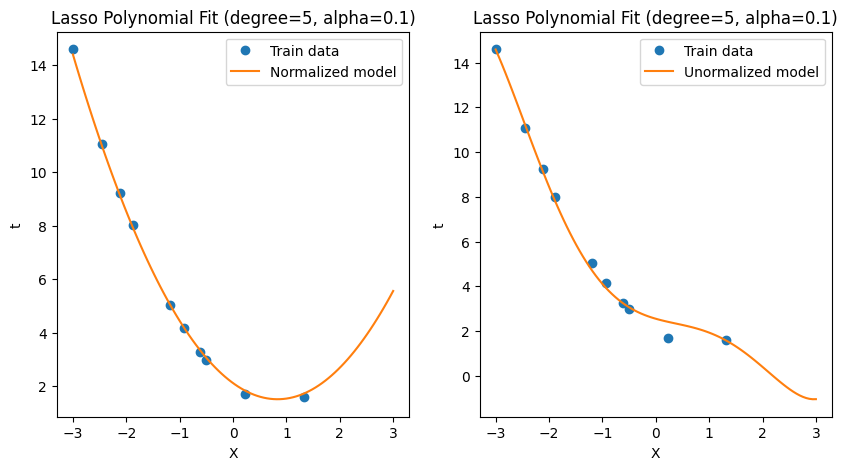

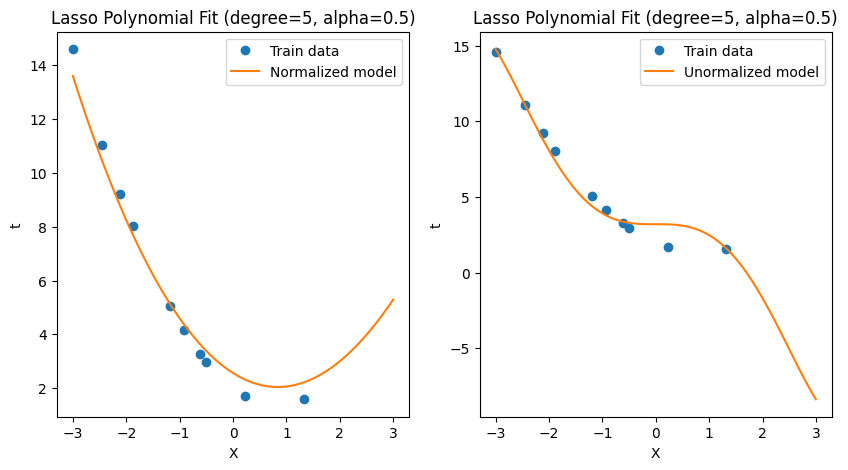

In [17]:
%matplotlib inline
plt.close("all")

## Generate dataset
poly_degree_data = 2
noise_var = 0.0
N_data = 10
xmin = -3
xmax = 3

X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree_data, noise_var, N_data, seed = 1)

# ===========
## Train model

# model specification
poly_degree_model = 5  # assume our data follows a polynomial of order 10
X_train_feat = generate_features(X_train_poly, poly_degree=poly_degree_model, add_bias = False)

for reg_coeff in [0.1, 0.5]:

    print("================================")
    print("================================")
    print("================================")
    print(f"Regularization coefficient {reg_coeff}")

    ## Figure grid
    fig, ax_list  = plt.subplots(1,2,figsize = (10,5))
    
    for id_fig,norm_data in enumerate([True, False]):
        if norm_data:
            ## ================
            ## Normalized Model
        
            # Normalize data 
            scaler_X = StandardScaler()
            # scaler_T = StandardScaler()
            X_train_feat_scaled = scaler_X.fit_transform(X_train_feat)
            t_train_poly_scaled = t_train_poly #scaler_T.fit_transform(t_train_poly).ravel()
        else:
            X_train_feat_scaled = X_train_feat
            t_train_poly_scaled = t_train_poly 
            
        
        # model
        lasso = Lasso(alpha=reg_coeff)
        
        # optimize model
        lasso.fit(X_train_feat_scaled, t_train_poly_scaled)
        
        # Print coefficient values
        print("=============")
        if norm_data:
            print("Normalized")
        else:
            print("Un normalized")
            
        print("Coeficientes óptimos:", lasso.coef_)
        print("Intercepto:", lasso.intercept_)
        
        # ===========
        ## Plot regressed model
        N_grid = 100
        x_grid = np.linspace(-3,3,N_grid)
        X_grid_feat = generate_features(x_grid, poly_degree=poly_degree_model, add_bias = False)
        if norm_data:
            X_grid_feat_scaled = scaler_X.transform(X_grid_feat)  # escalar mismo rango
        else:
            X_grid_feat_scaled = X_grid_feat
        
        # Predecir con el model
        y_grid = lasso.predict(X_grid_feat_scaled)
        #y_grid = scaler_T.inverse_transform(y_grid.reshape(-1, 1)).ravel()
        
        # Graficar
        ax_list[id_fig].plot(X_train_poly, t_train_poly, 'o', color='C0', label='Train data')
        if norm_data:
            ax_list[id_fig].plot(x_grid, y_grid, color='C1', label='Normalized model')
        else:
            ax_list[id_fig].plot(x_grid, y_grid, color='C1', label='Unormalized model')
        ax_list[id_fig].set_xlabel('X')
        ax_list[id_fig].set_ylabel('t')
        ax_list[id_fig].set_title(f'Lasso Polynomial Fit (degree={poly_degree_model}, alpha={reg_coeff})')
        ax_list[id_fig].legend()
    


## Cross Validation

There are many questions that naturally arise from the current analysis of regularization.

* How do we optimally select the value for $\lambda$?
* How do we know if it is better to use $L_1$ or $L_2$ regularization?
* What degree of polynomial (or what model) should we use?
* How can we measure if the regularization used has actually have an impact on the model performance?

My favourite answer to all this questions relies on Occam’s Razor and automatic model selection through marginal likelihoods, but this is often impractical for many applications, and a concept a bit difficult to understand when starting with Machine Learning. The idea basically relies on: "use the simpler model you can to explain your data". The marginal likelihood, automatically, encodes this information.

The answer we will see here is what is called cross validation. The idea is to mimic a real scenario in which part of the data is used to train the model, and part of the data is used to validate the model. Note that a model is fitted to minimize a loss function over a set of data, and very expressive models can yield a nearly zero error on them. But, how it will behave on new unseen data? The model we have fitted will need to explain this data well since it was not used to fit the model. We already observed how a very expressive model yield a very good training error but very poor test error.

Cross-validation exploits this idea by randomly partitioning the data into $M$ train-validation splits. The model is fitted on each train split and evaluated on its corresponding validation split. This is done for the $M$ models, and the one that has the lower error on average over the $M$ splits wins. 

Thus, we can test each parameter of our model using cross validation to decide which is the configuration to use. Once we have decided, the model is fitted to the train data and is ready to measure on the test data. The test data mimics the future data your model will need to explain when it is working in a real environment. This pipelines can be easily done in sklearn, for any model or parameter considered. To do so consider functionalities: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html and https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

##### Manual cross validation

Cross validation can be easily implemented using loops and a performance metric. Suppose we use squared error as the score metric. Let's see how we can choose optimal regularization parameter for the $L_2$ and $L_1$ models.

In [18]:
%matplotlib inline
plt.close("all")

## to draw model
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))

## ====================
## for video generation

## temporary filename
video_filename = "/tmp/aux.mp4"

## video writer
writer = imageio.get_writer(video_filename, format="FFMPEG", mode="I", fps=1, codec="libx264")


## Generate dataset
poly_degree_data = 2
noise_var = 0.5
N_data = 100
xmin = -3
xmax = 3

X_poly, t_poly = generate_polinomial_data(xmin, xmax, poly_degree_data, noise_var, N_data, seed = 1)

## grid for plotting
X_grid = np.linspace(-3,3,100)

## Model specs
# try 10 different lambda parameters
lambda_grid = np.linspace(0.1,10,5)
poly_degree_model = 10

X_poly_feats = generate_features(X_poly, poly_degree_model, add_bias = True)

# cross validation 
CV = 5

# try each paramteer CV times
loss = {}
valid_mean = []
train_mean = []
w_opts = []
for i,lam in enumerate(lambda_grid):
    
    loss[lam] = {
        'train' : [],
        'valid' : [],
    }

    loss_train = []
    loss_valid = []

    ## clear cross validation figure
    ax2.cla()
    
    for cv in range(CV):
        
        # Divide train-test
        X_temp, X_test, t_temp, t_test = train_test_split(
            X_poly, t_poly, test_size=0.2, random_state=cv
        )
        
        # Divide train validation
        X_train, X_valid, t_train, t_valid = train_test_split(
            X_temp, t_temp, test_size=0.25, random_state=cv
        )
    
    
        # Convert into polynomial features
        X_train_feats = generate_features(X_train, poly_degree_model, add_bias = True)
        X_valid_feats = generate_features(X_valid, poly_degree_model, add_bias = True)
        X_grid_feats = generate_features(X_grid, poly_degree_model, add_bias = True)

        # Fit model and save
        w_opt = fit_norm2_least_square(X_train_feats,t_train, lam = lam)

        # compute predictions on train, valid data and grid.
        y_train_feats = computation_graph_linear(  
                                               X_train_feats, 
                                               w_opt ,
                                               b = 0,
                                            )
        y_valid_feats = computation_graph_linear(  
                                               X_valid_feats, 
                                               w_opt ,
                                               b = 0,
                                            )

        y_grid = computation_graph_linear(  
                                               X_grid_feats, 
                                               w_opt ,
                                               b = 0,
                                            )

        # compute error on train and validation sets
        loss_train.append(float(np.sum(squared_loss_function(y_train_feats, t_train))))
        loss_valid.append(float(np.sum(squared_loss_function(y_valid_feats, t_valid))))

        # display function on each validation set
        if cv == 0:
            ax2.plot(X_poly, t_poly, '*', color = 'C0', label = 'all data')
            ax2.plot(X_train, t_train, '*', color = 'C1', label = 'train data')
            ax2.plot(X_valid, t_valid, '*', color = 'C2', label = 'valid data')
        else:
            ax2.plot(X_poly, t_poly, '*', color = 'C0')
            ax2.plot(X_train, t_train, '*', color = 'C1')
            ax2.plot(X_valid, t_valid, '*', color = 'C2')
            
        ax2.plot(x_grid, y_grid, color = f'C{cv+3}', label = f'$cv={cv}$')
        ax2.legend(loc = 'upper right')

        ## save video frame
        buf = BytesIO()
        fig.savefig(buf, format="png", dpi=100)
    
        buf.seek(0)
        frame = imageio.imread(buf) 
        writer.append_data(frame)  

        '''
        fig.canvas.draw()
        fig.canvas.flush_events()
        time.sleep(0.5)
        '''

    loss[lam]['train'] = loss_train
    loss[lam]['valid'] = loss_valid
    valid_mean.append(np.mean(loss_valid))
    train_mean.append(np.mean(loss_train))

    ## plot the trained model 
    w_opt = fit_norm2_least_square(X_poly_feats,t_poly, lam = lam)

    y_grid = computation_graph_linear(  
                                       X_grid_feats, 
                                       w_opt ,
                                       b = 0,
                                    )


    ax1.plot(X_poly, t_poly, '*', color = 'C0')
    ax1.plot(x_grid, y_grid, color = f'C{i+1}', label = f'$\lambda={lam}$')
    ax1.legend()

    ## save video frame
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100)

    buf.seek(0)
    frame = imageio.imread(buf) 
    writer.append_data(frame)  
    
## Once computed, get the one with lowest validation.
idx_train = np.argmin(train_mean)
idx_val = np.argmin(valid_mean)

## Model selected
print(f"Model with lowest training error {lambda_grid[idx_train]:.2f} with train error {train_mean[idx_train]:.2f}")
print(f"Model selected lambda {lambda_grid[idx_val]:.2f} with validation error {valid_mean[idx_val]:.2f}")

writer.close() 
plt.close()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 500) to (1008, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Model with lowest training error 0.10 with train error 10.91
Model selected lambda 0.10 with validation error 6.00


In [19]:
# Mostrar el video en Jupyter Notebook
display(Video(data=video_filename, embed=True))
os.remove(video_filename)

In [20]:
%matplotlib inline
plt.close("all")

## to draw model
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.set_ylim([-2,20])

## ====================
## for video generation

## temporary filename
video_filename = "/tmp/aux.mp4"

## video writer
writer = imageio.get_writer(video_filename, format="FFMPEG", mode="I", fps=1, codec="libx264")

## Generate dataset
poly_degree_data = 2
noise_var = 0.5
N_data = 30
xmin = -3
xmax = 3

X_poly, t_poly = generate_polinomial_data(xmin, xmax, poly_degree_data, noise_var, N_data, seed = 1)

## grid for plotting
X_grid = np.linspace(-3,3,100)

## Model specs
# try 10 different lambda parameters
poly_grid = [1,2,5,10,20]

# cross validation 
CV = 5

# try each paramteer CV times
loss = {}
valid_mean = []
train_mean = []
w_opts = []
for i,poly_degree_model in enumerate(poly_grid):
    
    X_poly_feats = generate_features(X_poly, poly_degree_model, add_bias = True)
    
    loss[poly_degree_model] = {
        'train' : [],
        'valid' : [],
    }

    loss_train = []
    loss_valid = []

    ## clear cross validation figure
    ax2.cla()
    ax2.set_ylim([-2,20])
    
    
    for cv in range(CV):
        
        # Divide train-test
        X_temp, X_test, t_temp, t_test = train_test_split(
            X_poly, t_poly, test_size=0.2, random_state=cv
        )
        
        # Divide train validation
        X_train, X_valid, t_train, t_valid = train_test_split(
            X_temp, t_temp, test_size=0.25, random_state=cv
        )
    
        # Convert into polynomial features
        X_train_feats = generate_features(X_train, poly_degree_model, add_bias = True)
        X_valid_feats = generate_features(X_valid, poly_degree_model, add_bias = True)
        X_grid_feats = generate_features(X_grid, poly_degree_model, add_bias = True)

        # Fit model and save
        w_opt = fit_norm2_least_square(X_train_feats,t_train, lam = 0.0)

        # compute predictions on train, valid data and grid.
        y_train_feats = computation_graph_linear(  
                                               X_train_feats, 
                                               w_opt ,
                                               b = 0,
                                            )
        y_valid_feats = computation_graph_linear(  
                                               X_valid_feats, 
                                               w_opt ,
                                               b = 0,
                                            )

        y_grid = computation_graph_linear(  
                                               X_grid_feats, 
                                               w_opt ,
                                               b = 0,
                                            )

        # compute error on train and validation sets
        loss_train.append(float(np.mean(squared_loss_function(y_train_feats, t_train))))
        loss_valid.append(float(np.mean(squared_loss_function(y_valid_feats, t_valid))))

        # display function on each validation set
        if cv == 0:
            ax2.plot(X_poly, t_poly, '*', color = 'C0', label = 'all data')
            ax2.plot(X_train, t_train, '*', color = 'C1', label = 'train data')
            ax2.plot(X_valid, t_valid, '*', color = 'C2', label = 'valid data')
        else:
            ax2.plot(X_poly, t_poly, '*', color = 'C0')
            ax2.plot(X_train, t_train, '*', color = 'C1')
            ax2.plot(X_valid, t_valid, '*', color = 'C2')
            
        ax2.plot(x_grid, y_grid, color = f'C{cv+3}', label = f'$cv={cv}$')
        ax2.legend(loc = 'upper right')

        
        ## save video frame
        buf = BytesIO()
        fig.savefig(buf, format="png", dpi=100)
    
        buf.seek(0)
        frame = imageio.imread(buf) 
        writer.append_data(frame) 

        '''
        fig.canvas.draw()
        fig.canvas.flush_events()
        time.sleep(0.5)
        '''
        
    loss[poly_degree_model]['train'] = loss_train
    loss[poly_degree_model]['valid'] = loss_valid
    valid_mean.append(np.mean(loss_valid))
    train_mean.append(np.mean(loss_train))

    ## plot the trained model 
    w_opt = fit_norm2_least_square(X_poly_feats,t_poly, lam = 0.0)

    y_grid = computation_graph_linear(  
                                       X_grid_feats, 
                                       w_opt ,
                                       b = 0,
                                    )


    ax1.plot(X_poly, t_poly, '*', color = 'C0')
    ax1.plot(x_grid, y_grid, color = f'C{i+1}', label = f'$poly degree={poly_degree_model}$')
    ax1.legend()

    ## save video frame
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100)

    buf.seek(0)
    frame = imageio.imread(buf) 
    writer.append_data(frame) 
    
## Once computed, get the one with lowest validation.
idx_train = np.argmin(train_mean)
idx_val = np.argmin(valid_mean)

## Model selected
print(f"Model with lowest training error poly degree = {poly_grid[idx_train]:.2f} with train error {train_mean[idx_train]:.2f}")
print(f"Model selected lambda poly degree = {poly_grid[idx_val]:.2f} with validation error {valid_mean[idx_val]:.2f}")

writer.close() 
plt.close()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 500) to (1008, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Model with lowest training error poly degree = 20.00 with train error 0.00
Model selected lambda poly degree = 2.00 with validation error 0.17


In [21]:
# Mostrar el video en Jupyter Notebook
display(Video(data=video_filename, embed=True))
os.remove(video_filename)

In [22]:
for k,v in loss.items():
    print(k)
    print(v)

1
{'train': [6.06605690038168, 5.041030029206408, 4.862609791076817, 5.025251938000519, 5.0191707446486875], 'valid': [3.495874011258131, 4.790536670355487, 5.510142578172125, 12.143430997567924, 5.995293867434615]}
2
{'train': [0.18409629357628862, 0.1428299204145027, 0.16163617062018293, 0.1389522440265413, 0.1381264178159119], 'valid': [0.09315792351332002, 0.2009949426014804, 0.21377520353728788, 0.03972960017388846, 0.27792458154729277]}
5
{'train': [0.17186903912077633, 0.1306806049437393, 0.133475878629941, 0.13338058922810994, 0.11846120240449737], 'valid': [0.055005713802573276, 0.18295351811558577, 0.2892309798841847, 0.028117889334400088, 0.2972692938185449]}
10
{'train': [0.045935675249963254, 0.0720027188879852, 0.06674597039676908, 0.05649992642538569, 0.0647947383936796], 'valid': [0.3339450863757278, 0.37571978064058986, 0.2324673546003303, 298.89141032843366, 0.6416947992084346]}
20
{'train': [0.0043613744273218, 0.0031000349785867054, 0.003637505581693367, 0.003744122

##### Cross validation with sklearn

In [23]:
## Generate dataset
poly_degree_data = 2
noise_var = 0.5
N_data = 10
xmin = -3
xmax = 3

X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree_data, noise_var, N_data, seed = 1)

# Pipeline of processing step till yield model fitting
pipeline = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
    ("reg", Ridge())  # Placeholder
])

# Hyperparameters
param_grid = [
    {   # L2
        "poly__degree": [1, 2, 3, 4, 5],
        "reg": [Ridge()],
        "reg__alpha": np.logspace(-3, 3, 7)
    },
    {   # L1
        "poly__degree": [1, 2, 3, 4, 5],
        "reg": [Lasso(max_iter=5000)],
        "reg__alpha": np.logspace(-3, 3, 7)
    }
]

# 10 fold cross validation
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=10,
    scoring="neg_mean_absolute_percentage_error",
    n_jobs=-1
)

grid.fit(X_train_poly, t_train_poly)

print("Best parameters:", grid.best_params_)
print("Best scores:", grid.best_score_)
print("Best Model:", grid.best_estimator_)
print("Cross validation: ", pd.DataFrame(grid.cv_results_).keys())
print("Cross validation: ", pd.DataFrame(grid.cv_results_))

Best parameters: {'poly__degree': 2, 'reg': Lasso(max_iter=5000), 'reg__alpha': np.float64(0.1)}
Best scores: -0.17095047398111898
Best Model: Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('reg', Lasso(alpha=np.float64(0.1), max_iter=5000))])
Cross validation:  Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_poly__degree', 'param_reg', 'param_reg__alpha', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'split5_test_score',
       'split6_test_score', 'split7_test_score', 'split8_test_score',
       'split9_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')
Cross validation:      mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.005497      0.005940         0.001615        0.000154   
1        0.003013      0.00

/home/jmaronasm/.conda/envs/ML2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.598e-01, tolerance: 9.050e-03
  model = cd_fast.enet_coordinate_descent(
/home/jmaronasm/.conda/envs/ML2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 1.561e-02
  model = cd_fast.enet_coordinate_descent(
